# Init Tdx 

In [1]:
# import logging
import sys

# stdout=sys.stdout
sys.path.append('../../')
import os
import random
import time

import matplotlib
import matplotlib.pyplot as plt
import mplfinance as mpf
# pip install --upgrade mplfinance
# sys.stdout=stdout
import numpy as np
# import numpy as np
import pandas as pd
from JohnsonUtil import commonTips as cct
from JSONData import sina_data
from JSONData import tdx_data_Day as tdd
from mplfinance.original_flavor import candlestick_ohlc

# from JSONData import tdx_hdf5_api as h5a

%matplotlib widget
plt.rc('font', family='SimHei', size=13)
matplotlib.get_backend()
# jupyter nbextension enable --py widgetsnbextension

os.environ['NUMEXPR_MAX_THREADS'] = '12'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import nest_asyncio

nest_asyncio.apply()

In [2]:
# code_list = sina_data.Sina().all.index.tolist()
# print(f'code_list:{len(code_list)}')
# df = tdd.search_Tdx_multi_data_duration('tdx_all_df_300', 'all_300', df=None,code_l=code_list, start=20170101, end=None,freq=None, col=None, index='date')

In [3]:
block_path = tdd.get_tdx_dir_blocknew() + '060.blk'

## 功能定义DEF

### ra_diff


In [4]:
def ra_diff(df):
    df['ra_diff'] = df.close.apply(lambda x: round(x / df.close.min(), 2))
    return df

### bullish 测算

In [5]:
import numpy as np


def calculate_slope(data):
    # Calculate the slope of the line that connects two points
    slope = round((data[1] - data[0]) / (1), 2)
    return slope


def detect_bull_bear(price_data, window=10):
    # Calculate the slopes of the price data for the last `window` days
    slopes = []
    for i in range(len(price_data) - window, len(price_data) - 1):
        slope = calculate_slope([price_data[i], price_data[i + 1]])
        # print(slope)
        slopes.append(slope)

    # Compare the current slope with the average slope of the last `window` days
    avg_slope = round(np.mean(slopes), 2)
    curr_slope = calculate_slope([price_data[-window], price_data[-1]])
    print(len(slopes), avg_slope, curr_slope)

    if curr_slope > avg_slope:
        # return "Bullish"
        return "Bull"
    else:
        return "Bear"


def detect_bull_bear_apply(price_data, window=10):
    # Calculate the slopes of the price data for the last `window` days
    slopes = []
    # try:
    if len(price_data) > 20:
        for i in range(len(price_data) - window, len(price_data) - 1):
            slope = calculate_slope([price_data[i], price_data[i + 1]])
            # print(slope)
            slopes.append(slope)

        # Compare the current slope with the average slope of the last `window` days
        avg_slope = round(np.mean(slopes), 2)
        curr_slope = calculate_slope([price_data[-window], price_data[-1]])
        # print(len(slopes), avg_slope, curr_slope)

        # if curr_slope > avg_slope:
        #     # return "Bullish"
        #     return "Bull"
        # else:
        #     return "Bear"
        return curr_slope
    else:
        return round((price_data[-1] - price_data[0]) / (1), 2)


code = '601360'
# Example usage
# price_data = [100, 95, 97, 99, 102, 105, 108, 111,1]
dfc = tdd.get_tdx_Exp_day_to_df(
    code, dl=60, resample='d').sort_index(
    ascending=True).reset_index()
# dfc = get_sina_data_cname(dfc)
price_data = dfc.close.values.tolist()
price_data[1], dfc.date[0]
price_data[-1], dfc.date[-1:]
print(detect_bull_bear(price_data))
print(detect_bull_bear_apply(price_data))

# Output: "Bullish"

(10.0, '2025-05-26')

(10.97,
 59    2025-08-18
 Name: date, dtype: object)

9 0.0 0.01
Bull
0.01


### regression_line(X, Y)
regression_ratio(df, window=10):

9.85 0.02
Above
0.02


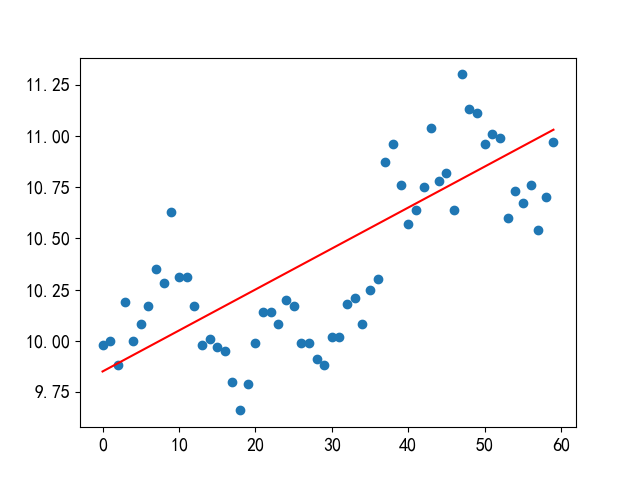

In [6]:


def regression_line(X, Y, limit=10,showall=False):
    # Calculate the coefficients of the regression line
    if not showall:
        X = X[-limit:]
        Y = Y[-limit:]
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x), 2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return a, b


def regression_ratio(df, window=10):
    # Calculate the coefficients of the regression line
    if isinstance(df, pd.Series):
        # Y = df.values[-window:]
        # X = df.reset_index().index[-window:]
        Y = df.values
        X = df.reset_index().index
    else:
        if 'close' in df.columns:
            df = df.reset_index()
            # X = df.index[-limit:]
            # Y = df.close[-limit:]
            X = df.index
            Y = df.close
        else:
            # Y = df.values[-limit:]
            # X = df.reset_index().index[-limit:]
            Y = df.values
            X = df.reset_index().index
            
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    # a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x),2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return b


def predict_price(time, a, b):
    # Predict the price using the regression line
    price = a + b * time
    return price


def plot_regression_line(X, Y, a, b):
    # Plot the regression line
    # plt.close()
    plt.scatter(X, Y)
    plt.plot(X, a + b * X, color="red")
    plt.show()


def detect_position(price, a, b, X):
    # Detect the position of the current price on the regression line
    regression_price = predict_price(X[-1], a, b)
    if price > regression_price:
        return "Above"
    elif price < regression_price:
        return "Below"
    else:
        return "On"


# Example usage
time_index = dfc.index
price = dfc.close.values
a, b = regression_line(time_index, price,showall=True)
print(a, b)
# Output: (100.0, 5.0)
print(detect_position(132, a, b, time_index))
print(regression_ratio(dfc))
plot_regression_line(time_index, price, a, b)

# print(detect_position(132, a, b, time))
# Output: "On"

9.85 0.02
Above
0.02


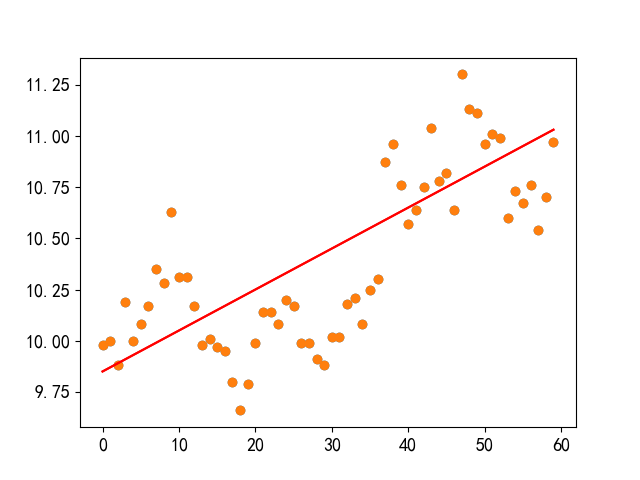

In [7]:


def regression_line(X, Y, limit=10,showall=False):
    # Calculate the coefficients of the regression line
    if not showall:
        X = X[-limit:]
        Y = Y[-limit:]
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x), 2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return a, b


def regression_ratio(df, window=10):
    # Calculate the coefficients of the regression line
    if isinstance(df, pd.Series):
        # Y = df.values[-window:]
        # X = df.reset_index().index[-window:]
        Y = df.values
        X = df.reset_index().index
    else:
        if 'close' in df.columns:
            df = df.reset_index()
            # X = df.index[-limit:]
            # Y = df.close[-limit:]
            X = df.index
            Y = df.close
        else:
            # Y = df.values[-limit:]
            # X = df.reset_index().index[-limit:]
            Y = df.values
            X = df.reset_index().index
            
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    # a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x),2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return b


def predict_price(time, a, b):
    # Predict the price using the regression line
    price = a + b * time
    return price


def plot_regression_line(X, Y, a, b):
    # Plot the regression line
    # plt.close()
    plt.scatter(X, Y)
    plt.plot(X, a + b * X, color="red")
    plt.show()


def detect_position(price, a, b, X):
    # Detect the position of the current price on the regression line
    regression_price = predict_price(X[-1], a, b)
    if price > regression_price:
        return "Above"
    elif price < regression_price:
        return "Below"
    else:
        return "On"


# Example usage
time_index = dfc.index
price = dfc.close.values
a, b = regression_line(time_index, price,showall=True)
print(a, b)
# Output: (100.0, 5.0)
print(detect_position(132, a, b, time_index))
print(regression_ratio(dfc))
plot_regression_line(time_index, price, a, b)

# print(detect_position(132, a, b, time))
# Output: "On"

In [8]:
dfc.columns

Index(['date', 'code', 'open', 'high', 'low', 'close', 'vol', 'amount',
       'lower', 'ene',
       ...
       'max5', 'max10', 'hmax', 'hmax60', 'high4', 'llowvol', 'low10', 'low60',
       'low4', 'lastdu4'],
      dtype='object', length=175)

### check_postion_vol_price

In [9]:
from sklearn.linear_model import LinearRegression


def check_postion_vol_price(df):
    # 加载数据
    # df = pd.read_csv("data.csv")

    # 创建输入数据
    X = df[["close", "vol"]].values
    y = df["close"].values

    # 训练回归模型
    reg = LinearRegression().fit(X, y)

    # 计算斜率和截距
    slope = reg.coef_[0]
    intercept = reg.intercept_

    # 计算上轨和下轨
    upper_band = slope * df["close"] + intercept + 2 * df["vol"]
    lower_band = slope * df["close"] + intercept - 2 * df["vol"]

    # 判断价格是否在通道内
    df["Positon"] = np.where(
        df["close"] > upper_band, "Long", np.where(
            df["close"] < lower_band, "Short", "Neutral"))
    return df


dfc = check_postion_vol_price(dfc)
dfc[-1:]

date    code   open   high    low  close          vol        amount  \
59  2025-08-18  601360  10.75  11.15  10.75  10.97  208310848.0  2.290982e+09   

    lower   ene  ...  max10  hmax  hmax60  high4     llowvol  low10  low60  \
59   10.4  10.8  ...  11.01  11.3   10.63  10.76  47601280.0  10.54   9.66   

    low4   lastdu4  Positon  
59  10.5  1.509434  Neutral  

[1 rows x 176 columns]

In [10]:

# dfc=  dfc.rename(columns={'date': 'Date', "open":"Open","high":"High","low": "Low","close":"Close"})
dfc.columns
# dfc[["Date", "Open", "High", "Low", "Close"]][-2:]
dfc.date[:3]
dfc.date = pd.to_datetime(dfc.date)
# dfc.set_index('date')
dfc.date[-1:]

Index(['date', 'code', 'open', 'high', 'low', 'close', 'vol', 'amount',
       'lower', 'ene',
       ...
       'max10', 'hmax', 'hmax60', 'high4', 'llowvol', 'low10', 'low60', 'low4',
       'lastdu4', 'Positon'],
      dtype='object', length=176)

0    2025-05-26
1    2025-05-27
2    2025-05-28
Name: date, dtype: object

59   2025-08-18
Name: date, dtype: datetime64[ns]

### show_ohlc_upper 

xratio:0.02 
code: 601360


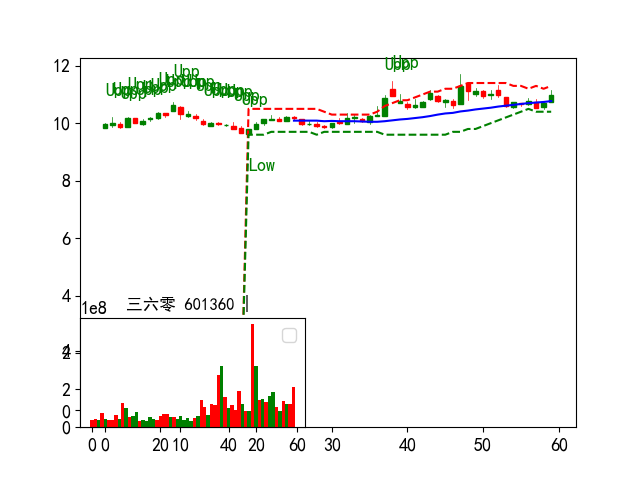

In [11]:

def show_ohlc_upper(df, code=None, allshow=True):
    # 加载数据
    # df = pd.read_csv("data.csv")
    # plt.close()
    # 计算OHLC数据
    # df = df.rename(columns={'date': 'Date', "open": "Open",
    #                "high": "High", "low": "Low", "close": "Close"})
    # df.Date = df.Date.apply(lambda x:str(x).replace('-',''))
    if 'name' not in df.columns and code is not None:
        df['name']= tdd.get_sina_data_code(code)
    if allshow:
        if 'ra_diff' in df.columns:
            print("xratio:%s ra_diff:%s" % (regression_ratio(df),df.ra_diff[-1]))
        else:
            print("xratio:%s " % (regression_ratio(df)))
    # df=df[df.upper > 0]
    df = df.rename(columns={'vol': 'volume'})
    df = df.reset_index()
    # df.date = pd.to_datetime(df.index)
    df.date = df.index
    # print(df.Date)
    # ohlc = df[["Date", "Open", "High", "Low", "Close"]].values
    ohlc = df[["date", "open", "high", "low", "close", 'volume']].values

    # 计算上轨和下轨
    # upper_band = df[df.upper != 0].upper
    # lower_band = df[df.lower != 0].lower
    upper_band = df.upper
    lower_band = df.lower
    
    # print(lower_band,df.lower)
    # print(upper_band,df.upper)

    if 'ma20d' in df.columns:
        ma20d = df[df.ma20d > 0].ma20d
    elif 'ma20' in df.columns:
        ma20d = df[df.ma20 > 0].ma20
    else:
        print('not ma20 ma20d')
    idx = len(df) - len(upper_band)
    idx2 = len(df) - len(lower_band)
    if idx != idx2:
        print(idx, len(df), len(upper_band))
        print(idx2, len(lower_band))

    # 计算当前价格的位置
    position = ['' for i in range(len(df))]
    # print(idx,len(df) ,len(upper_band),position)
    
        # else:
            # position[i] = 'Middle Band'
    # print(position)
    # 绘制OHLC图
    fig, ax = plt.subplots()
    candlestick_ohlc(ax, ohlc, width=0.6, colorup='g', colordown='r')

    # 添加上轨和下轨
    
    for i in range(idx, len(upper_band), 1):
        # print(df["close"][i])
        # print(upper_band[i],df["low"][i])
        # print(i,lower_band[i])
        #error upper_band ==0.0
        if df["close"][i] > upper_band[i]:
            position[i] = 'Upp'
        elif df["low"][i] < lower_band[i]:
            position[i] = 'Low'
            
    plt.plot(upper_band.index, upper_band, 'r--', label='Upper Band')
    plt.plot(lower_band.index, lower_band, 'g--', label='Lower Band')
    
    plt.plot(ma20d.index, ma20d, 'b', label='ma20')

    if 'hat' in df.columns:
        plt.plot(df.hat.index, df.hat, 'g', label='hat')
    # 添加位置
    for i, txt in enumerate(position):
        if txt == 'Low':
            plt.annotate(txt, (df["date"][i], df["close"][i]), xytext=(
                0, -30), textcoords='offset points', color='g')
        else:
            plt.annotate(txt, (df["date"][i], df["close"][i]), xytext=(
                0, 20), textcoords='offset points', color='g')
    axx = fig.add_subplot(325)
    # axx.plot(df[["volume"]])
    # from matplotlib import transforms
    # pad = 0.25
    # yl = ax.get_ylim()
    # ax.set_ylim(yl[0]-(yl[1]-yl[0])*pad,yl[1])
    # axx = ax.twinx()
    # axx.set_position(transforms.Bbox([[0.125,0.1],[0.9,0.32]]))

    volume = np.asarray(df.volume)
    pos = df['open'] - df['close'] < 0
    neg = df['open'] - df['close'] >= 0
    idx = np.asarray([x for x in range(len(df.date))])
    # print len(dates),len(df),ax.get_xlim(),ax.get_xticks()
    axx.bar(idx[pos], volume[pos], color='red', width=1, align='center')
    axx.bar(idx[neg], volume[neg], color='green', width=1, align='center')

    # position = ['' for i in range(len(df))]
    # position = df.Positon
    # for i, txt in enumerate(position):
    #     plt.annotate(txt, (df["Date"][i], df["Close"][i]), xytext=(0,20), textcoords='offset points')
    # 添加图例
    plt.legend(loc='best')
    # plt.legend(["Now:%s" % df.close[-1], "Hi:%s" % df.high[-1], "Lo:%0.2f" % (asset.iat[-1]), "day:%s" %
    #             len(asset), "fib:%s" % (fib),"MA:%s"%(roll_mean_days)], fontsize=12, loc=0)
    if 'name' in df.columns:
        if 'code' in df.columns:
            plt.title(df.name.values[-1:][0] + " " + df.code[0] + " | ", fontsize=12)
        else:
            plt.title(str(df.name.values[-1:][0]) + " " + " | ", fontsize=12)

    else:
        if 'code' in df.columns:
            plt.title(" | " + df.code[0] + " | ", fontsize=12)
        else:
            if code is None:
                plt.title(" | " + " | ", fontsize=12)
            else:
                plt.title(" | " + code + " | ", fontsize=12)

    # 显示图形
    print("code:",code)
    plt.show()


show_ohlc_upper(dfc,code=dfc.code[0])

In [12]:
'code' in dfc.columns

True

### show_channel_mpl

In [13]:
dfc['position'] = 0


def show_channel_mpl_bug(df, limit=60):
    # Compute the channel
    def compute_channel(df):
        # Compute the high and low of the past n periods
        n = 20
        high = df['high'].rolling(window=n, min_periods=n).max()
        low = df['low'].rolling(window=n, min_periods=n).min()
        df['upper_channel'] = high + (high - low) * 0.5
        df['lower_channel'] = low - (high - low) * 0.5

        # Update the position based on the current price
        df['position'] = np.where(df['close'] > df['upper_channel'] * 0.66, 1,
                                  np.where(df['close'] < df['lower_channel'], -1, 0))
        # print(df['position'])

    df = df.rename(columns={'vol': 'volume'})
    # df = df.reset_index()
    if 'date' in df.columns:
        df.date = pd.to_datetime(df.date)
    else:
        df = df.reset_index()
        df.date = pd.to_datetime(df.date)
    df = df.set_index('date')
    # df.date = df.index
    df = df.loc[:, ["open", "high", "low", "close", 'volume']]
    compute_channel(df)

    # fig, ax = plt.subplots()
    # Plot the ohlc chart
    mpf.plot(df, type='candle', title='OHLC chart with channel and position',
             ylabel='Price', volume=True, mav=(10, 20),
             show_nontrading=False, ylabel_lower='Position')
    # returnfig=True)

    # for i, txt in enumerate(df.position):
    #     # print(i,txt,df.index[i], df["close"][i])
    #     if txt == 0:
    #         plt.annotate("Down", (df.index[i], df["close"][i]), xytext=(
    #             0, -30), textcoords='offset points', color='g')
    #     else:
    #         plt.annotate("UP", (df.index[i], df["close"][i]), xytext=(
    #             0, 20), textcoords='offset points', color='g')

    # axlist[0].set_yticks([-1, 0, 1])
    # axlist[2].xaxis.set_ticks(df['position'])
    # axlist[2].set_xticklabels(df['upper_channel'])
    # yticks=[-1, 0, 1], yticklabels=['Sell', 'Hold', 'Buy'],
    # overlays=[(df['upper_channel'], None), (df['lower_channel'], None)])
# show_channel_mpl(dfc)

## TDX def

In [14]:
global sina_dm
sina_dm = None


def get_sina_data_cname(df, dm=None, index=False, realtime=False):
    # index_status=False
    global sina_dm
    if dm is None:
        if sina_dm is None:
            dm = sina_data.Sina().market('all')
        else:
            dm = sina_dm.copy()

    if 'ticktime' in df.columns:
        time_l = time.mktime(dm.loc[:, 'ticktime'][-1].timetuple())
        dur = round((time.time() - time_l) / 60, 2)
        if dur > 5:
            print("timel > 5,renew dm")
            dm = sina_data.Sina().market('all')
            sina_dm = dm.copy()

    if realtime:
        print("compute percent")
        df.rename(columns={'low': 'llow',
                  'high': 'lhigh', 'open': 'lopen'}, inplace=True)
        if 'nclose' in dm.columns:
            dd = cct.combine_dataFrame(
                df, dm.loc
                [:,
                 ['nclose', 'close', 'name', 'open', 'high', 'low', 'llastp',
                  'ticktime']],
                clean=True)
        else:
            dd = cct.combine_dataFrame(
                df, dm.loc
                [:, ['close', 'name', 'open', 'high', 'low', 'llastp', 'ticktime']],
                clean=True)
        dd['perc'] = ((dd['close'] - dd['llastp']) / dd['llastp'] *
                      100).map(lambda x: round(x, 2))
        # dd = cct.combine_dataFrame(df, dm['name'])

    else:
        dd = cct.combine_dataFrame(df, dm['name'])
    # cname = sina_data.Sina().get_code_cname(code)
    return dd


def write_code_to_blk(codew, blk='060'):
    block_path = tdd.get_tdx_dir_blocknew() + '%s.blk' % (blk)
    write_blk = 'n'
    write_blk = cct.cct_raw_input("write blk [Y] or [N]:")
    if write_blk == 'y' or write_blk == 'Y':
        hdf5_wri = cct.cct_raw_input(
            "Rewrite code [Y] or append [N](defalut:N):")
        if hdf5_wri == 'y' or hdf5_wri == 'Y':
            append_status = False
        else:
            append_status = True
        if len(codew) > 3:
            cct.write_to_blocknew(block_path, codew, append_status,
                                  doubleFile=False, keep_last=0)
            ("write:%s block_path:%s" % (len(codew), block_path))
        else:
            ("write error:%s block_path:%s" % (len(codew), block_path))
    return True

def get_multiIndex_drop_last_row(df,dropline=1):

    return df.drop(level='date', labels=df.index.get_level_values('date')[-dropline])

def clean_688(df):
    df = df[(~df.index.str.contains("688"))]
    return df

def clean_sina_dm(dd):
    if (cct.get_now_time_int() > 915 and cct.get_now_time_int() < 926):
        dd = dd[dd.close > 0]
    else:
        dd = dd[dd.open > 0]
    return dd

def compute_perd_value(df, market_value=3, col="vol", col_new='volsum'):

    # if market_value == None or market_value < "2":
    #     market_value = 3
    # if market_value > 1 and len(df[ df["%s%sd" % (col, market_value)] > 2])   :
    market_value = str(market_value)
    if market_value > str(1):
        temp = df[
            df.columns[
                (df.columns >= "%s1d" % (col)) &
                (df.columns <= "%s%sd" % (col, market_value))
            ]
        ]

        df['%s%sd' % (col_new, market_value)] = temp.T.sum().apply(
            lambda x: round(x, 1))
    else:
        print("market_value <= 1,No Compute")

    return df


def show_tdx_data(df, codelist=None, market_value='3', col=None,limit=20,orderby='percent'):
    col_src = [
        "name",'percent', "couts", "date", "perc", "ra_diff","xratio", "idx", "hat", "close",
        "volsum5d", "hmax", "lmin", "perc1d", "ma20", "ma250", "nclose",
        "llow", 'vol1d', 'vol2d', 'vol3d', 'vol4d', 'vol5d', "perc%sd" %
        (market_value),
        "perc5d"]

    if isinstance(df, pd.Series):
        col_name = [co for co in col_src if co in df.index]
        # col_name.insert(1,'date')
    else:
        col_name = [co for co in col_src if co in df.columns]

    # print(col_name)
    # if isinstance(df, pd.DataFrame) and 'name' in df.columns:
    #     columns_ = col_name
    # else:
    #     if isinstance(df, pd.Series) and 'name' in df.index:
    #         columns_ = col_name.insert(1, "date")
    #     else:
    #         columns_ = col_name.remove("name")
    if orderby in df.columns:
        df=df.sort_values('percent', ascending=False)
    if isinstance(col,list):
        col_name.extend(col)
    elif col is not None:
        col_name.insert(4, col)

    if codelist is None:
        if isinstance(df, pd.Series):
            print("Count:1")
            temp = df.loc[col_name][:limit]
        else:
            print("Count:%s %s" % (df.shape))
            temp = df.loc[:, col_name][:limit]
    else:
        temp = df.loc[[x for x in codelist if x in df.index], col_name][:limit]
    return temp

def get_multi_date_duration(df, dt):
    dd = df.reset_index()
    dd = dd[dd.date >= dt]
    # dd['couts'] = dd.groupby(['code'])['code'].transform('count')
    dd = dd.set_index(['code', 'date'])
    return dd


def get_multi_code_count(df, col='code'):
    dd = df.reset_index()
    dd['couts'] = dd.groupby([col])[col].transform('count')
    dd = dd.sort_values(by=['couts', 'date'], ascending=[0, 1])
    print('count dd.couts')
    dd = dd.set_index(['code', 'date'])
    return dd


def multindex_iloc(df, index):
    label = df.index.levels[0][index]
    return df.iloc[df.index.get_loc(label)]


def get_groupby_mean_median_close(dfs):

    groupd = dfs.groupby(level=[0])

    df = groupd['close'].agg(['median', 'mean'])
    df['close'] = groupd.tail(1).reset_index().set_index(['code'])['close']
    # dfs['mean'] = groupd['close'].agg('mean')
    # dfs['median'] = groupd['close'].agg('median')

    # dfs = dfs.fillna(0)
    # idx = pd.IndexSlice
    # mask = ( (dfs['mean'] > dfs['median'])
    #         & (dfs['close'] > dfs['mean'])
    #         )
    # df=dfs.loc[idx[mask, :]]

    df = df[(df['mean'] > df['median']) & (df['close'] > df['mean'])]

    # dt_low = None
    # if dl == 1:
    #     dfs = groupd.tail(1)
    #     print("dfs tail1")
    # else:
    #     dl = 30
    #     dindex = tdd.get_tdx_Exp_day_to_df(
    #         '999999', dl=dl).sort_index(ascending=False)
    #     dt = tdd.get_duration_price_date('999999', df=dindex)
    #     dt = dindex[dindex.index >= dt].index.values
    #     dt_low = dt[-1]
    #     dtlen = len(dt) if len(dt) >0 else 1
    #     dfs = groupd.tail(dtlen)
    #     print("dfs tail:%s dt:%s"%(dtlen,dt))
    #     dfs = get_multi_date_duration(dfs,dt[-1])
    return df


def compute_df_Col_lastday(dfs, col='close', colre='perc', days=3, plus=True):
    for da in range(int(days)):
        da += 1
        if plus:
            dfs['%s%sd' % (colre, da)] = round(
                (dfs[col] - dfs[col].shift(da)) / dfs[col].shift(da) * 100, 2)
        else:
            if da == 1:
                dfs['%s%sd' % (colre, da)] = round(
                    (dfs[col] - dfs[col].shift(da)) / dfs[col].shift(da) * 100, 2)
            else:
                dfs['%s%sd' % (colre, da)] = round(
                    (dfs[col].shift(da - 1) - dfs[col].shift(da)) / dfs[col].shift(da) * 100, 2)
    return dfs

In [15]:
def get_roll_mean_all(
        single=True, tdx=False, app=True, duration=100, ma_250_l=1.3,
        ma_250_h=1.3, resample='d'):
    time_s = time.time()
    if not app and cct.get_file_size(block_path) > 100 and cct.creation_date_duration(block_path) == 0:
        print("It's Today Update")
        return True
    code_list = sina_data.Sina().all.index.tolist()
#     .Sina().all.index.tolist()
    code_list.extend(['999999', '399001', '399006'])
    print("all code:", len(code_list))
    if duration < 300:
        h5_fname = 'tdx_all_df' + '_' + str(300)
        h5_table = 'all' + '_' + str(300)
    else:
        h5_fname = 'tdx_all_df' + '_' + str(900)
        h5_table = 'all' + '_' + str(900)
    print(f'h5_fname:{h5_fname} h5_table:{h5_table}')
#     df = tdd.search_Tdx_multi_data_duration('tdx_all_df_300', 'all_300', df=None,code_l=code_list, start='20170501', end=None, freq=None, col=None, index='date')
#     df = tdd.search_Tdx_multi_data_duration(h5_fname, h5_table, df=None, code_l=code_list, start=None, end=None,
#         freq=None, col=None, index='date')
    df = tdd.search_Tdx_multi_data_duration('tdx_all_df_300', 'all_300', df=None,code_l=code_list, start=20170101, end=None,freq=None, col=None, index='date')
    # df = tdd.search_Tdx_multi_data_duration(h5_fname, h5_table, df=None,code_l=code_list, start=None, end=None, freq=None, col=None, index='date',tail=1)
    print(f'df:{df}')
    code_uniquelist = df.index.get_level_values('code').unique()

    code_select = code_uniquelist[random.randint(0, len(code_uniquelist) - 1)]
    print(round(time.time() - time_s, 2), df.index.get_level_values(
        'code').unique().shape, code_select, df.loc[code_select].shape)
    # df.groupby(level=[0]),df.index.get_level_values(0)
    # len(df.index.get_level_values('code').unique())
    # df = df[~df.index.duplicated(keep='first')]

    # multiIndex_func = {'close': 'mean', 'low': 'min', 'high': 'max', 'volume': 'sum', 'open': 'first'}
    # cct.using_Grouper(df, freq='W', col={'close': 'last'})
    # *** TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'
    # roll_dl = duration
    if resample != 'd':

        print("resample:%s"%(resample.upper()))
        df = df.groupby(level=0).resample(resample, level=1).last()
        df = df.dropna()
        
    ''' 
    if resample != 'd':
        print("resample:%s" % (resample.upper()))
        # ohlc_dict = {'volume': 'sum','high': 'max','low': 'min','close': 'last'}
        # {'low': 'min', 'close':'mean'}
        # df = df.groupby(level=0).resample(resample, level=1).agg({'close':'last'})
        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(level=0).resample(resample, level=1).agg({'close':'last'})
        df = df.loc[:, ['close']].groupby(level=0).resample(
            resample, level=1).agg({'close': 'last'}).dropna()

        df = df.dropna()
        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(level=0).resample(resample, level=1, how={'low': 'min', 'close':'mean'})
        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(pd.Grouper(freq=resample)).transform(np.cumsum).resample(resample, how='ohlc')

        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(pd.TimeGrouper(resample)).transform(np.cumsum).resample(resample, how='ohlc')
        # r1 = len(df.loc['000001'])
        # r2 = len(df.loc['999999'])
        # roll_dl = r1 if r1 < r2 else r2

        # df['upper'] = map(lambda x: round((1 + 11.0 / 100) * x, 1), df.ma10d)
        # df['lower'] = map(lambda x: round((1 - 9.0 / 100) * x, 1), df.ma10d)
        # df['ene'] = map(lambda x, y: round((x + y) / 2, 1), df.upper, df.lower)
        # dfs['amount%d'%cumdays] = groupd['amount'].apply(pd.rolling_mean, cumdays)
    # df.ix[df.index.levels[0]]
    # df.ix[df.index[len(df.index)-1][0]] #last row
    # dfs = tdd.search_Tdx_multi_data_duration(df=dfs,code_l=code_list, start='20170918', end='20170918', freq=None, col=None, index='date')

    # print dfs[:1],len(dfs)
    # groupd.agg({'low': 'min'})
    #  idx mask filter 
    # h5a.write_hdf_db('all300', df, table='roll200', index=False,baseCount=500, append=False, MultiIndex=MultiIndex)
    '''

    df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code', 'date'])
    print("use time:%s" % (round(time.time() - time_s, 2)))
    return df

# 读取数据 TDX Days

## resample = 'D'

In [16]:
# resample = 'W-FRI'
resample = 'D'

df = get_roll_mean_all(
    single=False, tdx=True, app=True, duration=250, ma_250_l=1.2,
    ma_250_h=1.2, resample=resample)


# df= df.groupby(level=[0]).tail(1).reset_index().set_index('code')
# df_cname = tdd.get_sina_datadf_cnamedf(df.index.tolist(), df)
# df = df.reset_index().set_index(['code', 'date'])

all code: 5200
h5_fname:tdx_all_df_300 h5_table:all_300
df:                      open     high      low    close          vol  \
code   date                                                          
999999 2023-11-02  3028.00  3038.00  3010.00  3010.00  268794592.0   
       2023-11-03  3012.00  3040.00  3012.00  3030.00  268486336.0   
       2023-11-06  3048.00  3058.00  3038.00  3058.00  372949632.0   
       2023-11-07  3052.00  3064.00  3042.00  3058.00  326853440.0   
       2023-11-08  3052.00  3062.00  3038.00  3052.00  335677824.0   
...                    ...      ...      ...      ...          ...   
301061 2025-08-18   109.00   115.00   106.81   110.50    1804634.0   
300889 2025-08-18    15.70    16.06    15.70    15.85    5010820.0   
301386 2025-08-18    23.72    24.00    23.70    23.91    2045145.0   
300252 2025-08-18    12.63    14.35    12.63    14.12  113662568.0   
300614 2025-08-18    15.14    15.40    15.08    15.14    2869629.0   

                         amoun

In [17]:
# df.loc['399001'][-1:]
df.loc['000002'][-1:]
# df.groupby(level=[0]).tail(30).groupby(level=[0]).tail(2)
# df.groupby(level=[0]).tail(30).groupby(level=[0]).head(1)

open  high   low  close          vol       amount
date                                                         
2025-08-18  6.53  6.56  6.48    6.5  138162544.0  898811520.0

### Test InStock

In [18]:
df.loc['301083'][:2]

open   high    low  close        vol       amount
date                                                          
2023-11-02  15.78  16.22  15.50  15.50  1845500.0   29343732.0
2023-11-03  15.86  17.83  15.73  16.91  9484947.0  160420160.0

## ra_diff

In [19]:
tail_days = 60

In [20]:
df = df.groupby(level=[0]).tail(tail_days).groupby(level=[0]).apply(ra_diff)


In [21]:
# df.loc['999999'][-3:]
# df.loc['301073'].ra_diff[-3:]
df.loc['300459'].shape

(60, 7)

## X df_regression_ratio outdate
    df_idx_detect

In [22]:
# df_reg_ratio = df.groupby(level=[0])['close'].apply(regression_ratio)
# df_idx_detect = df.groupby(level=[0])['close'].apply(detect_bull_bear_apply)
# show_ohlc_upper()
# df[:10]

In [23]:
# df_idx_detect.shape, df_idx_detect.loc['000002']
# df.loc['000002'][-2:],df_reg_ratio.loc['000002']
# df.loc['688798'][-3:]

In [24]:
# df.loc['000002'][-10:]

## sina_dm

In [25]:
sina_dm = sina_data.Sina().market('all')
lastday = cct.last_tddate()
lastday,sina_dm.name[:1]
sina_dm = clean_sina_dm(sina_dm)

('2025-08-16',
 code
 600339    中油工程
 Name: name, dtype: object)

In [26]:
cct.get_time_to_date(time.time(), format='%Y-%D %H:%M:%S')

# abc=dm.loc[:,'ticktime'][-1]
sina_dm.ticktime[-2:]
# dm.ticktime[:1]
# sina_dm.loc[:, 'ticktime'][-1]
# time.strptime(abc,format='%Y-%m-%d %H:%M:%S')
# (time.mktime(abc.timetuple()))
(time.time() - time.mktime(sina_dm.loc[:, 'ticktime'][-1].timetuple())) / 60

'2025-08/18/25 16:26:26'

code
300345   2025-08-18 15:00:00
000605   2025-08-18 15:00:00
Name: ticktime, dtype: datetime64[ns]

86.43572864929835

### Combine ratio and idx

In [27]:
# if 'date' in df.columns:
#     print('error duplicated date col')
#     if isinstance(df,pd.MultiIndex):
#         df.drop('date', axis=1, inplace=True)
# else:
#     df = df.reset_index().set_index('code')
#     df['idx'] = df_idx_detect
#     df['xratio'] = df_reg_ratio
#     df['name'] = sina_dm.name
#     df = df.reset_index().set_index(['code', 'date'])

## 读取实时成交量数据

In [28]:
def apply_col_toint(df, col=None):
    if col is None:
        co2int = ['boll', 'op', 'ratio', 'fib', 'fibl', 'df2']
    # co2int.extend([co for co in df.columns.tolist()
    #                if co.startswith('perc') and co.endswith('d')])
        co2int.extend(['top10', 'topR'])
    else:
        co2int = col
    co2int = [inx for inx in co2int if inx in df.columns]

    for co in co2int:
        df[co] = df[co].astype(int)

    return df

def readHdf5(fpath, root=None):
    store = pd.HDFStore(fpath, "r")
    print(store.keys())
    if len(store.keys()) > 0 and root is None and store is not None:
        root = store.keys()[0].replace("/", "")
        df = store[root]
        df = apply_col_toint(df)
    else:
        df = None
    store.close()
    return df

In [29]:
# tdx_path = "G:\\tdx_last_df.h5"
# from JohnsonUtil import commonTips as cct
sina_MultiD_path = f"{cct.get_ramdisk_dir()}\\sina_MultiIndex_data.h5".replace('\\',os.sep)
print(f'sina_MultiD_path:{sina_MultiD_path}')
h5 = readHdf5(sina_MultiD_path)
print(sina_MultiD_path)
if h5 is not None:
    h5.shape
    h5code='603019'
    h5.loc[h5code][-3:]
    code_muti = '603019'
    # h5.loc[code_muti][:2]

    freq = 'D'
    # freq = '5M'
    startime = '09:25:00'
    endtime = '15:01:00'

    time_ratio = cct.get_work_time_ratio()
    time_ratio
    run_col = ['close', 'volume']
    # run_col = ['close']
    mdf = cct.get_limit_multiIndex_freq(
        h5, freq=freq.upper(),
        col=run_col, start=startime, end=endtime, code=None)
    allvol = mdf.volume.sum()
    allvol = round(allvol / 10 / 1000 / 1000,2)
    print("总量:%s 亿"%(allvol))
    mdf['vol']=mdf['volume'].apply(lambda x: round(x /1000/1000,2)) 
    mdf['amount']=(mdf.volume * mdf.close).map(lambda x: round(x/100/1000/1000, 2))
    #全局占比
    mdf['volume'] = mdf.amount.apply(
        lambda x: round(x / allvol * 100 / time_ratio, 2))
    mdf=mdf.reset_index().set_index('code')
    mdf.loc[h5code]
else:
    mdf = None

sina_MultiD_path:G:\sina_MultiIndex_data.h5
['/all_30']
G:\sina_MultiIndex_data.h5


(5113848, 6)

close  high    low  llastp    volume  lastbuy
ticktime                                                          
2025-08-18 14:58:40  74.56  75.5  73.75   73.62  71537144    74.56
2025-08-18 15:00:01  74.50  75.5  73.75   73.62  72444281    75.31
2025-08-18 15:00:01  74.50  75.5  73.75   73.62  72444281    74.25

1.0

总量:17329.71 亿


ticktime    2025-08-19 00:00:00
close                 74.815035
volume                     0.31
vol                       72.44
amount                     54.2
Name: 603019, dtype: object

In [30]:
if mdf is not None:
    mdf[:2]
    mdf.loc['603019']

ticktime      close  volume     vol  amount
code                                                
000001 2025-08-19  12.082402    0.09  123.91   14.97
000002 2025-08-19   6.507390    0.05  138.16    8.99

ticktime    2025-08-19 00:00:00
close                 74.815035
volume                     0.31
vol                       72.44
amount                     54.2
Name: 603019, dtype: object

In [31]:
# h5.index.get_level_values('code')[0]
# help(h5.index.get_level_values)
if h5 is not None:
    str(h5.index.get_level_values(1)[-1])[:10]

'2025-08-18'

In [32]:
if mdf is not None and len(mdf) > 0:
    mdf.loc['000002']
else:
    print("mdf is None")

ticktime    2025-08-19 00:00:00
close                   6.50739
volume                     0.05
vol                      138.16
amount                     8.99
Name: 000002, dtype: object

###  实时成交量个股Top!!!

In [33]:
if mdf is not None and len(mdf) > 0:
    nowdf = mdf.sort_values(by=['volume'], ascending=[0])
    # nowdf.shape, df.shape, code_idx.shape
    # top20_nd = nowdf.reset_index().loc[:, ['code', 'volume']][:20]
    top20_nd = nowdf.reset_index().loc[:, ['code', 'volume']][:20]
    top20_nd=get_sina_data_cname(top20_nd)
    nowdf.shape,top20_nd
else:
    top20_nd = None

((5189, 5),
         volume  name
 code                
 300059    2.61  东方财富
 300803    0.94   指南针
 000063    0.86  中兴通讯
 300033    0.71   同花顺
 300502    0.70   新易盛
 300308    0.70  中际旭创
 600111    0.70  北方稀土
 601138    0.67  工业富联
 600580    0.66  卧龙电驱
 600030    0.65  中信证券
 688256    0.64   寒武纪
 601162    0.63  天风证券
 300476    0.57  胜宏科技
 300339    0.51  润和软件
 002104    0.51  恒宝股份
 600392    0.47  盛和资源
 300750    0.47  宁德时代
 601606    0.45  长城军工
 688981    0.45  中芯国际
 002837    0.44   英维克)

In [34]:
# show_tdx_data(top20_nd)
# top20_nd.columns

### 合并实时成交量及SinaDM

In [35]:
from JSONData import tdx_hdf5_api as h5a
def get_tdx_all_from_h5(resample='d',showtable=True):
    #sina_monitor
    h5_fname = 'tdx_last_df'
    resample=resample
    if resample=='d':
        dl='60'
    else:
        dl='200'
    filter='y'
    h5_table = 'low' + '_' + resample + '_' + str(dl) + '_' + filter + '_' + 'all'
    h5 = h5a.load_hdf_db(h5_fname, table=h5_table,code_l=None, timelimit=False,showtable=showtable)
    return h5


In [36]:
# mdf[:1]
if mdf is not None and len(mdf) > 0:
    sinadm = cct.combine_dataFrame(sina_dm, mdf[['vol','amount']])
else:
    sinadm = sina_dm

sinadm['percent']=((sinadm['close']-sinadm['llastp'])/(sinadm['llastp'])*100).round(1)


In [37]:
h5tdx = get_tdx_all_from_h5(resample='w')
tdx_now_w = cct.combine_dataFrame(h5tdx,sinadm)

keys:['/low_3d_120_y_all', '/low_d_60_y_all', '/low_m_300_y_all', '/low_w_200_y_all']


In [38]:
tdx_now_w.query('close > lastp1d and lastp1d > lastp2d and lastp2d >lastp3d and close > high4')

lopen  lhigh   llow  lastp         lvol       lamount   lower     ene  \
code                                                                            
000004   7.57   7.90   7.19   7.73   19144076.0  1.726949e+08    7.70    9.00   
000006   6.26   6.45   6.10   6.15  539259072.0  3.919416e+09    6.00    6.60   
000011   8.28   8.29   7.16   7.89  260167536.0  2.652926e+09    7.70    8.50   
000014   9.93  10.18   9.78   9.90  167620544.0  2.473863e+09    9.50   11.60   
000016   4.90   4.94   4.53   4.54  801687680.0  4.295170e+09    4.50    5.00   
...       ...    ...    ...    ...          ...           ...     ...     ...   
873726  21.14  21.41  20.30  20.31   32341838.0  1.139150e+09   24.41   29.30   
920002  46.28  51.47  43.38  47.06    7590631.0  9.596484e+08  104.81  140.00   
920060  30.34  30.75  28.91  29.30   52674564.0  1.957743e+09   27.00   32.31   
920088  22.94  24.28  21.62  22.16   28731260.0  1.155269e+09   18.00   33.50   
920445   7.25   7.72   6.90   7.09   21416380.0  2.366902e+08    9.10   10.20   

         upper  bandwidth  ...   close         nvol    nlow   nhigh  nclose  \
code                       ...                                                
000004   10.30      28.45  ...    9.41    9054101.0    9.25    9.47    9.45   
000006    7.20      18.42  ...    7.70  104852579.0    7.47    7.62    7.66   
000011    9.40      19.45  ...   10.18   42251165.0   10.02   10.37   10.16   
000014   13.70      36.25  ...   16.53   40022046.0   15.28   15.66   16.23   
000016    5.50      19.70  ...    5.47  162300967.0    5.34    5.52    5.52   
...        ...        ...  ...     ...          ...     ...     ...     ...   
873726   34.19      33.34  ...   43.81    7891414.0   36.59   37.88   42.06   
920002  175.25      50.28  ...  131.62    2917635.0  126.56  128.00  129.50   
920060   37.69      33.16  ...   39.94   12969280.0   38.31   39.28   39.62   
920088   49.00      92.62  ...   40.22    4571421.0   39.12   39.50   39.78   
920445   11.40      22.77  ...   11.59    6258033.0   11.13   11.33   11.45   

        nstd  lastbuy     vol  amount  percent  
code                                            
000004  -2.0     9.45    9.05    0.86      2.1  
000006  -2.0     7.66  104.85    8.03      5.0  
000011  -2.0    10.16   42.25    4.29      1.3  
000014  -2.0    16.23   40.02    6.50      8.9  
000016  -2.0     5.52  162.30    8.96      2.6  
...      ...      ...     ...     ...      ...  
873726  -2.0    42.06    7.89    3.32     17.4  
920002  -2.0   129.50    2.92    3.77      3.8  
920060  -2.0    39.62   12.97    5.14      4.3  
920088  -2.0    39.78    4.57    1.82      1.7  
920445  -2.0    11.45    6.26    0.72      3.2  

[1275 rows x 222 columns]

### tdx_last_df and Now sina!!! RealTIME

In [39]:
tdx_h5=get_tdx_all_from_h5()
tdx_now = cct.combine_dataFrame(tdx_h5,sinadm)

keys:['/low_3d_120_y_all', '/low_d_60_y_all', '/low_m_300_y_all', '/low_w_200_y_all']


In [40]:
tdx_now.shape
# tdx_now.query('close >  lastp1d  and lastl1d < ma51d and close > ma51d and lastp1d < upper and lastp1d > lastp2d and lasth1d >high4 and boll > 0 and volume < 1')
tdx_select = tdx_now.query('close > lastp1d and percent < 3')[:10]
show_tdx_data(tdx_select,limit=10)

(5190, 223)

Count:10 223


name  percent        date  close   hmax   lmin  perc1d  nclose  \
code                                                                      
000021    深科技      2.9  2025-06-20  19.84  19.41  17.98     0.0   19.73   
000016   深康佳Ａ      2.6  2025-06-20   5.47   5.42   4.75     0.0    5.52   
000004  *ST国华      2.1  2025-06-20   9.41   9.35   8.52     0.1    9.45   
000009   中国宝安      2.1  2025-06-19   9.36   9.33   8.67     0.1    9.28   
000017   深中华A      1.4  2025-07-31   6.51   6.65   6.16     0.0    6.47   
000010   美丽生态      1.3  2025-05-23   4.66   5.10   2.94     0.0    4.66   
000011   深物业A      1.3  2025-06-19  10.18  10.52   8.34    -1.0   10.16   
000025   特 力Ａ      0.9  2025-06-20  17.66  18.23  16.81     0.0   17.67   
000008   神州高铁      0.7  2025-06-19   2.88   2.93   2.73     0.0    2.89   
000020   深华发Ａ      0.6  2025-05-23  13.98  14.33  13.07     0.0   14.05   

         llow  perc3d  perc5d  
code                           
000021  16.80     0.1     1.3  
000016   4.55    15.7    16.0  
000004   8.52     1.2     0.1  
000009   7.90     0.1     1.3  
000017   6.16     0.1     0.1  
000010   2.79    -1.1    24.2  
000011   8.19     1.2    17.3  
000025  16.78     0.1     9.4  
000008   2.70     0.1     1.3  
000020  12.02     0.1     0.1

In [41]:
tdx_now.query('close.isna()').buy
# tdx_h5.loc['301397']
tdx_filter = tdx_now.query('low < ma5d*1.01 and close > max5 and close >hmax and percent > 1 and close > upper and boll > 1 and not code.str.contains("688")')

show_tdx_data(tdx_filter)

code
399001   NaN
399006   NaN
399005   NaN
999999   NaN
000627   NaN
300280   NaN
300326   NaN
301517   NaN
600150   NaN
601989   NaN
603058   NaN
603161   NaN
603389   NaN
605255   NaN
688228   NaN
688347   NaN
Name: buy, dtype: float64

Count:201 223


name  percent        date  close   hmax   lmin  perc1d  nclose   llow  \
code                                                                            
300995  奇德新材     20.0  2025-06-03  55.72  49.59  40.69    -0.1   53.41  33.31   
301086   鸿富瀚     18.2  2025-05-27  67.00  59.41  44.12     1.1   65.19  41.66   
833509  同惠电子     16.5  2025-07-31  29.64  26.64  24.23     0.0   28.12  24.30   
300731  科创新源     15.0  2025-05-29  59.50  52.16  27.80     1.2   56.53  24.98   
836807  奔朗新材     14.4  2025-05-28  22.55  21.20  13.88     0.1   21.56  10.45   
301133  金钟股份     12.5  2025-06-20  28.09  25.19  22.20     0.0   27.39  20.73   
301255  通力科技     11.0  2025-06-13  34.78  32.16  29.16     0.1   33.66  28.22   
300453  三鑫医疗     10.9  2025-06-19  11.10  10.75   8.14     0.1   10.52   7.70   
301509  金凯生科     10.7  2025-06-19  41.75  40.81  37.09     0.0   41.59  33.91   
300409  道氏技术     10.7  2025-06-03  20.88  18.55  15.30     0.0   19.97  13.61   
600881  亚泰集团     10.2  2025-06-03   2.16   1.95   1.77     0.1    2.14   1.71   
603339  四方科技     10.0  2025-06-20  14.58  13.43  11.91     0.0   14.34  11.16   
001202  炬申股份     10.0  2025-05-23  15.72  14.48  12.80    -0.1   15.22  12.21   
600990  四创电子     10.0  2025-05-26  31.88  29.66  25.75     0.0   31.62  22.44   
002981  朝阳科技     10.0  2025-05-30  33.25  31.80  25.92     0.1   31.27  22.48   
000628  高新发展     10.0  2025-06-20  56.88  53.72  41.03     0.0   56.72  41.16   
603320  迪贝电气     10.0  2025-05-30  21.38  20.73  17.89     0.1   21.14  16.20   
301310   鑫宏业     10.0  2025-06-20  46.47  43.59  35.81     0.0   44.50  33.78   
000782  恒申新材      9.9  2025-07-31   5.42   5.18   4.69    -0.1    5.36   4.70   
001298   好上好      9.9  2025-05-23  34.41  33.19  28.05     0.0   34.28  18.91   

        perc3d  perc5d  
code                    
300995    0.10   20.91  
301086   -0.90   16.09  
833509    0.10   -0.10  
300731   21.09   23.59  
836807    0.00    0.00  
301133   19.20    1.30  
301255    0.10    0.00  
300453   -0.90   16.30  
301509    0.10    1.30  
300409   18.80    0.00  
600881    1.20    1.20  
603339    1.30    1.30  
001202    1.20    0.10  
600990    0.00    1.10  
002981    1.10   25.30  
000628    1.20   17.30  
603320    0.00    0.10  
301310    1.20   15.90  
000782    0.00   19.41  
001298    0.10    0.00

#### 新高test!!!!!!

In [42]:
# write_code_to_blk(tdx_filter.index.tolist(),'rqg')

In [43]:
sinadm.shape
sinadm.columns
# sinadm['percent']=((sinadm['close']-sinadm['llastp'])/(sinadm['llastp'])*100).round(1)
# sinadm['percent'] = sinadm['percent'].round(1)
sinadm.query('percent > 6 ')

(5177, 45)

Index(['name', 'open', 'llastp', 'now', 'trade', 'high', 'low', 'buy', 'sell',
       'volume', 'turnover', 'b1_v', 'b1', 'b2_v', 'b2', 'b3_v', 'b3', 'b4_v',
       'b4', 'b5_v', 'b5', 'a1_v', 'a1', 'a2_v', 'a2', 'a3_v', 'a3', 'a4_v',
       'a4', 'a5_v', 'a5', 'dt', 'ticktime', 'b1_vv', 'close', 'nvol', 'nlow',
       'nhigh', 'nclose', 'timel', 'nstd', 'lastbuy', 'vol', 'amount',
       'percent'],
      dtype='object')

name   open  llastp    now  trade   high    low    buy   sell  \
code                                                                    
002046  国机精工  30.41   30.42  33.47    0.0  33.47  30.41  33.47   0.00   
300684  中石科技  35.03   34.12  37.09    0.0  38.38  34.44  37.09  37.09   
002733  雄韬股份  21.50   20.62  22.69    0.0  22.69  21.41  22.69   0.00   
002368  太极股份  26.27   26.25  28.05    0.0  28.66  26.27  28.05  28.05   
601777  千里科技  10.25   10.16  10.79    0.0  10.96  10.25  10.78  10.79   
...      ...    ...     ...    ...    ...    ...    ...    ...    ...   
688091  上海谊众  76.50   76.50  81.75    0.0  83.62  76.50  81.75  81.75   
834021  流金科技   7.33    7.27   8.03    0.0   8.25   7.33   8.03   8.04   
000062  深圳华强  29.19   26.53  29.19    0.0  29.19  28.34  29.19   0.00   
300854  中兰环保  16.69   16.55  18.02    0.0  18.05  16.45  18.00  18.02   
301226  祥明智能  35.00   33.53  40.25    0.0  40.25  35.00  40.25   0.00   

          volume  ...      nvol   nlow  nhigh  nclose         timel  nstd  \
code              ...                                                       
002046  67199806  ...  67199806  30.41  31.88   33.19  1.755501e+09  -2.0   
300684  45720829  ...  45720829  34.91  35.81   36.59  1.755501e+09  -2.0   
002733  37593960  ...  37593960  21.41  22.69   22.64  1.755501e+09  -2.0   
002368  38938627  ...  38938627  26.27  26.52   27.06  1.755501e+09  -2.0   
601777  74616954  ...  74616954  10.25  10.51   10.75  1.755501e+09  -2.0   
...          ...  ...       ...    ...    ...     ...           ...   ...   
688091   6393699  ...   6393699  76.50  83.00   81.56  1.755501e+09  -2.0   
834021  51519913  ...  51519913   7.33   7.55    7.98  1.755501e+09  -2.0   
000062  37991404  ...  37991404  28.34  29.19   29.19  1.755501e+09  -2.0   
300854   8677873  ...   8677873  16.45  16.69   17.14  1.755501e+09  -2.0   
301226  14244278  ...  14244278  35.00  36.44   39.25  1.755501e+09  -2.0   

        lastbuy    vol  amount  percent  
code                                     
002046    33.19  67.20   22.31     10.0  
300684    36.59  45.72   16.73      8.7  
002733    22.64  37.59    8.52     10.0  
002368    27.06  38.94   10.53      6.9  
601777    10.75  74.62    8.02      6.2  
...         ...    ...     ...      ...  
688091    81.56   6.39    5.21      6.9  
834021     7.98  51.52    4.11     10.5  
000062    29.19  37.99   11.09     10.0  
300854    17.14   8.68    1.48      8.9  
301226    39.25  14.24    5.61     20.0  

[366 rows x 45 columns]

## check HDF LastDate

In [44]:
df_tail1 = df.groupby(level=[0]).tail(1)
# df_tail1.index

#今日的code
df_tail1[df_tail1.index.get_level_values('date') == cct.get_today()].shape

#没有今日的code
df_tail1[df_tail1.index.get_level_values('date') != cct.get_today()].shape

(4909, 7)

(21, 7)

In [45]:
# df_tail1

In [46]:
df_tail1[df_tail1.index.get_level_values('date') != cct.get_today()][:1]

open   high    low  close        vol       amount  ra_diff
code   date                                                                   
689009 2024-12-26  45.12  46.09  44.88  45.09  6335058.0  288399168.0     1.05

In [47]:
# df.info()
# code_t = '600519'
# print(dfNow.loc[code_t][-3:])
# df.loc['000001'][-1:]
# dfbak = df.copy()
# df[(df.idx > df.idx.shift(1)) & (df.xratio > df.xratio.shift(1))].shape


## reindex sort date

In [48]:
# df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code','date'])

## 初始化参数

In [49]:
app = True
tdx = True
duration = 300
ma_250_l = 1.02
ma_250_h = 1.2

if resample.upper() == 'D' or resample.lower() == 'd':
    if duration < 300:
        rollma = ['10', '5', '20']
    else:
        rollma = ['10', '5', '20', '250']

elif resample.upper() == 'W' or resample.lower() == 'w':
    rollma = ['5', '10']
else:
    rollma = ['5', '10']
        

def init_MulitiData_Roll(df,resample='d',duration=300):
    time_s = time.time()
    dfs = df.copy()
    # dfs = df.loc['600519']
    # groupd = dfs.groupby(level=[0])
    # groupd.['close']
    # rollma = ['5','10','60','100','200']
    # rollma = ['5','10','250']
    # df.index.get_level_values('code')[0]
    if resample.upper() == 'D' or resample.lower() == 'd':
        if duration < 300:
            rollma = ['10', '5', '20']
        else:
            rollma = ['10', '5', '20', '250']

    elif resample.upper() == 'W' or resample.lower() == 'w':
        rollma = ['5', '10','20']
    else:
        rollma = ['5', '10','20']

    # rollma.extend([str(duration)])

    # import ipdb;ipdb.set_trace()
    # df.loc['300130'][:2]

    # dfs['mean'] = groupd['close'].agg('mean')
    # dfs['median'] = groupd['close'].agg('median')

    # BOLL:MA(CV,N), COLORMAGENTA;
    # UPPER:BOLL+P*STD(CV,N), COLORYELLOW;
    # LOWER:BOLL-P*STD(CV,N), COLORYELLOW;
    # df['BollUpper'] = df.close.shift(10).mean()+2*df.close.shift(10).std()
    # df['BollDown'] = df.close.shift(10).mean()-2*df.close.shift(10).std()
    for da in rollma:
        cumdays = int(da)
        dfs['ma%d' % cumdays] = round(dfs['close'].rolling(cumdays).mean(), 2)

        # dfs['upper'] = dfs['ma%d' % cumdays].apply(
        #     lambda x: round((1 + 11.0 / 100) * x, 1))
        # dfs['lower'] = dfs['ma%d' % cumdays].apply(
        #     lambda x: round((1 - 9.0 / 100) * x, 1))
        # dfs['boll'] = list(map(lambda x, y: round(
        #     (x + y) / 2, 1), dfs['upper'], dfs['lower']))
    if duration > 100:
        dfs['upper'] = round(
            dfs['close'].rolling(20).mean() + 2 *
            dfs['close'].rolling(20).std(),
            2)
        dfs['lower'] = round(
            dfs['close'].rolling(20).mean() - 2 *
            dfs['close'].rolling(20).std(),
            2)

        dfs['boll'] = round(dfs['close'].rolling(20).mean(), 2)

        dfs['hmax'] = round(dfs['high'].rolling(20).max(), 2)
        dfs['lmin'] = round(dfs['low'].rolling(20).min(), 2)

        dfs['hat'] = dfs['upper'] - dfs['lower']

        # dfs['hmax'] = round(dfs['close'].cummax(), 2)


    dfs = compute_df_Col_lastday(dfs, col='close', colre='perc', days=5)
    dfs = compute_df_Col_lastday(dfs, col='vol', colre='vol', days=5, plus=False)
    dfs = compute_perd_value(dfs, market_value=5, col='vol', col_new='volsum')

    return dfs
# dfs['perc1d'] = round(
#     (dfs['close'] - dfs['close'].shift(1)) / dfs['close'].shift(1) * 100, 2)
# dfs['perc3d'] = round(
#     (dfs['close'] - dfs['close'].shift(3)) / dfs['close'].shift(3) * 100, 2)
# dfs['perc5d'] = round(
#     (dfs['close'] - dfs['close'].shift(5)) / dfs['close'].shift(3) * 100, 2)

In [50]:
dfsRoot=init_MulitiData_Roll(df,resample=resample)

### DFS MutiIndex Test 0507

In [51]:
# dfs.loc['000002'][-5:].upper
dfsRoot.loc['603357'][-5:][['close','upper','low','boll']][-2:]
dftemp = dfsRoot.loc['603357']
dftemp[dftemp.close > dftemp.upper][:2]
print(dftemp.shape)

close  upper   low  boll
date                                
2025-08-15   8.76   8.87  8.70  8.73
2025-08-18   8.80   8.88  8.75  8.73

open  high   low  close        vol      amount  ra_diff  ma10  \
date                                                                        
2025-07-25  8.92  8.93  8.79    8.8  7449512.0  65776696.0     1.05  8.62   

             ma5  ma20  ...  perc2d  perc3d  perc4d  perc5d  vol1d  vol2d  \
date                    ...                                                 
2025-07-25  8.67  8.62  ...    2.44    1.97    0.92    1.97  86.29  -3.45   

            vol3d  vol4d  vol5d  volsum5d  
date                                       
2025-07-25  -1.52 -39.13  -8.76      33.4  

[1 rows x 28 columns]

(60, 28)


In [52]:
# dfs.loc['688027']
dfsRoot['ma51d'] = round(dfsRoot['close'].rolling(5).mean(), 2)
show_tdx_data(dfsRoot.loc['600519'][-2:],col=['ma51d','ra_diff'])
# show_tdx_data(dfs.loc['600519'])

Count:2 29


ra_diff    hat   close  volsum5d    hmax    lmin  perc1d    ma20  \
date                                                                           
2025-08-15     1.01  48.06  1422.0     170.1  1491.0  1410.0   -0.35  1428.7   
2025-08-18     1.02  47.86  1428.0      16.9  1491.0  1410.0    0.42  1428.9   

             ma250  vol1d  vol2d  vol3d  vol4d   vol5d  perc3d  perc5d  \
date                                                                     
2025-08-15  363.98  -1.14 -26.55  55.95 -10.90  152.79   -1.04    0.07   
2025-08-18  369.63  -0.43  -1.14 -26.55  55.95  -10.90    0.56   -1.18   

             ma51d  ra_diff  
date                         
2025-08-15  1430.2     1.01  
2025-08-18  1426.8     1.02

### Append Now SinaTo MultiIndex dfNow

In [53]:
# tail_days = 60
# cct.get_today()
def get_Append_Sina_To_MultiTDX(df,sina_dm):
    if cct.get_work_time_duration():
        sina_today=sina_dm.copy()
        if not isinstance(sina_today,pd.MultiIndex) and  'date' not  in sina_today.columns:
            sina_today['date']=pd.to_datetime(cct.get_today())
            print('concat1 init:sina_today:%s'%(sina_today.index[0]))
            # df_reg_ratio2 = df.groupby(level=[0])['close'].apply(regression_ratio)
            # df_idx_detect2 = df.groupby(level=[0])['close'].apply(detect_bull_bear_apply)
            # sina_today['idx'] = df_idx_detect2
            # sina_today['xratio'] = df_reg_ratio2
            # sina_today=sina_today.loc[:,['open','high','low','close','date','idx',y'xratio']].reset_index().set_index(['code', 'date'])
            if 'vol' in sina_today.columns:
                sina_today=sina_today.loc[:,['open','high','low','close','vol','amount','name','date']].reset_index().set_index(['code', 'date'])
            else:
                sina_today=sina_today.loc[:,['open','high','low','close','date']].reset_index().set_index(['code', 'date'])

        if sina_today.index[0] not in df.index:
            # df.index=df.index.append(sina_dm.index)
            print('concat1:sina_today:%s %s'%(sina_today.index[0]))
            df = pd.concat([df, sina_today])


    #         sina_today=sina_dm.copy()
    #         #drop line and append idx
    #         if not isinstance(sina_today,pd.MultiIndex) and  'date' not  in sina_today.columns:
    #             sina_today['date']=pd.to_datetime(cct.get_today())
    #             print('concat2 init:sina_today:%s'%(sina_today.index[0]))

    #             sina_today['idx'] = df_idx_detect2
    #             sina_today['xratio'] = df_reg_ratio2
    #             sina_today=sina_today.loc[:,['open','high','low','close','date','name','idx','xratio']].reset_index().set_index(['code', 'date'])
    #             # sina_today=sina_today.loc[:,['open','high','low','close','date']].reset_index().set_index(['code', 'date'])   


    #         df = get_multiIndex_drop_last_row(df,dropline=1)

            if sina_today.index[0] not in df.index:
                # df.index=df.index.append(sina_dm.index)
                print('concat2:sina_today:%s %s'%(sina_today.index[0]))
                df = pd.concat([df, sina_today])
            df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code','date'])
    return df

# dfNow=get_Append_Sina_To_MultiTDX(df.groupby(level=[0]).tail(30),sina_dm)


if resample.upper() == 'D':
    dfsRoot=get_Append_Sina_To_MultiTDX(dfsRoot.groupby(level=[0]).tail(tail_days),sinadm)
    dfNow= dfsRoot.groupby(level=[0]).tail(tail_days/2)
    
    dfNow=init_MulitiData_Roll(dfNow,resample=resample,duration=20)
else:
    dfNow = dfsRoot.groupby(level=[0]).tail(tail_days/2).copy()
# df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code','date'])
# df[-2:]
dfNow[-2:]

open   high    low  close          vol        amount  \
code   date                                                                
000001 2025-08-15  12.23  12.23  11.94  12.08  194850288.0  2.344073e+09   
       2025-08-18  12.06  12.15  12.03  12.08  123905840.0  1.496527e+09   

                   ra_diff   ma10    ma5   ma20  ...  perc3d  perc4d  perc5d  \
code   date                                      ...                           
000001 2025-08-15      1.1  12.33  12.23  12.42  ...   -2.03   -1.79   -2.58   
       2025-08-18      1.1  12.31  12.19  12.37  ...   -1.47   -2.03   -1.79   

                   vol1d  vol2d  vol3d  vol4d  vol5d  volsum5d  ma51d  
code   date                                                            
000001 2025-08-15  57.01  10.83  64.66 -27.22  12.60     117.9  12.23  
       2025-08-18 -36.41  57.01  10.83  64.66 -27.22      68.9  12.19  

[2 rows x 29 columns]

In [54]:
dfsRoot.groupby(level=[0]).tail(60).loc['000002'][-1:]


open  high   low  close          vol       amount  ra_diff  ma10  \
date                                                                           
2025-08-18  6.53  6.56  6.48    6.5  138162544.0  898811520.0     1.02  6.47   

             ma5  ma20  ...  perc3d  perc4d  perc5d  vol1d  vol2d  vol3d  \
date                    ...                                                
2025-08-18  6.48  6.53  ...    0.62    0.46    0.31  -13.4  32.79  48.19   

            vol4d  vol5d  volsum5d  ma51d  
date                                       
2025-08-18  10.42 -10.66      67.3   6.48  

[1 rows x 29 columns]

### Xratio and tail 60 MultiIndex 

In [55]:
## dfNow['xratio'] = dfNow['close'].rolling(30).apply(regression_ratio)
if 'xratio' not in dfNow.columns:
    df_xratio = dfNow.groupby(level=[0])['close'].rolling(24).apply(regression_ratio)
    df_xratio.index =df_xratio.to_frame().index.droplevel(1)
    dfNow['xratio'] = df_xratio

In [56]:
# df_xratio.loc['605589'][-8:]
dfsRoot.loc['603019'][:1]
# dfNow[-12:][-2:]

open   high    low  close         vol        amount  ra_diff  \
date                                                                        
2025-04-22  64.88  64.88  63.81  63.91  22737480.0  1.457704e+09     1.03   

             ma10    ma5   ma20  ...  perc3d  perc4d  perc5d  vol1d  vol2d  \
date                             ...                                         
2025-04-22  14.64  20.04  11.95  ...  606.97  598.47  595.43  364.7  16.57   

            vol3d  vol4d  vol5d  volsum5d  ma51d  
date                                              
2025-04-22 -30.24   3.99   95.3     450.3  20.04  

[1 rows x 29 columns]

## DFNow Query check

In [57]:
dfNow_A = dfNow.query('@dfNow.index.get_level_values(0) < "688000"')
# dfxra = dfNow_A.groupby(level=[0]).tail(3).query('xratio - xratio.shift(1) > (xratio.shift(1) - xratio.shift(2))*1.1')
# dfNow.groupby(level=[0]).tail(3)
lastworkday = cct.last_tddate(1)
print(lastworkday)
# dfxra.groupby(level=[0]).tail(1).query('date >= @lastworkday').xratio
# dfxra.query('@dfxra.index.get_level_values(0) < "688000"')
# dfxra.query('not @dfxra.index.get_level_values(0).str.contains("688") ')

# df.query(f'ColumnName >= {VariableName}')

# dfxra = dfNow_A.groupby(level=[0]).tail(3).query('0 > xratio > -0.08 and xratio - xratio.shift(1) > (xratio.shift(1) - xratio.shift(2))*1.1')

# dfxra = dfNow_A.groupby(level=[0]).tail(3).query('xratio > 0 and xratio.shift(1) < 0 and xratio - xratio.shift(1) > (xratio.shift(1) - xratio.shift(2))*1.1')

dfxra = dfNow_A.groupby(level=[0]).tail(3).query('high > upper  and xratio - xratio.shift(1) > (xratio.shift(1) - xratio.shift(2))')

dfxra.query('date >= @lastworkday').sort_values(by='xratio',ascending=0).xratio[:10]
# dfxra.query('date >= @lastworkday').xratio[:10]

# dfxra.query('date >= @lastworkday').loc['605589'].xratio
df_xratio.loc['605369'][-8:]

2025-08-16


code    date      
399001  2025-08-18    40.95
399006  2025-08-18    13.61
300308  2025-08-18     4.37
300502  2025-08-18     3.92
300476  2025-08-18     3.85
300033  2025-08-18     3.14
300757  2025-08-18     2.07
301095  2025-08-18     1.71
300395  2025-08-18     1.69
300620  2025-08-18     1.69
Name: xratio, dtype: float64

date
2025-08-07     NaN
2025-08-08    0.03
2025-08-11    0.03
2025-08-12    0.04
2025-08-13    0.05
2025-08-14    0.05
2025-08-15    0.05
2025-08-18    0.05
Name: close, dtype: float64

In [58]:
# dfNow['idx'] = dfNow['close'].rolling(25).apply(detect_bull_bear_apply)
df_idx = dfNow.groupby(level=[0])['close'].rolling(25).apply(detect_bull_bear_apply)
df_idx.index =df_idx.to_frame().index.droplevel(1)
dfNow['idx'] = df_idx

### dfNow Top

date
2025-08-15    5.83
2025-08-18    5.84
Name: upper, dtype: float64

(60, 29)
xratio:0.01 ra_diff:1.14
code: 300459


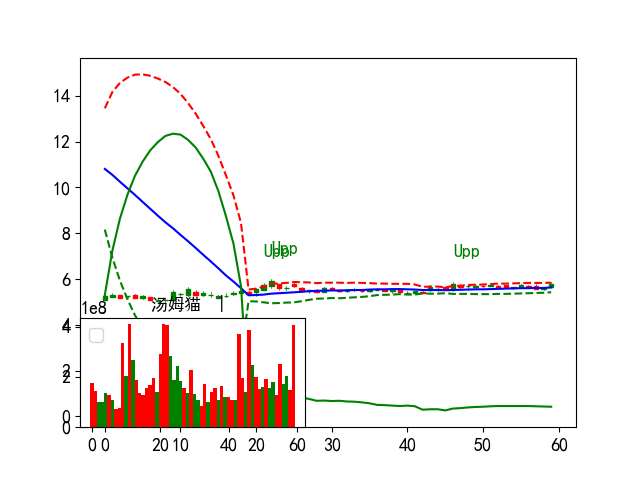

In [59]:
dfNow.loc['300459'][-2:].upper
print(dfsRoot.loc['300459'][-tail_days:].shape)
show_ohlc_upper(dfsRoot.loc['300459'][-tail_days:],code='300459')

In [60]:
# '302132' in dfsRoot.index

300059
xratio:0.07 ra_diff:1.35
code: 300059


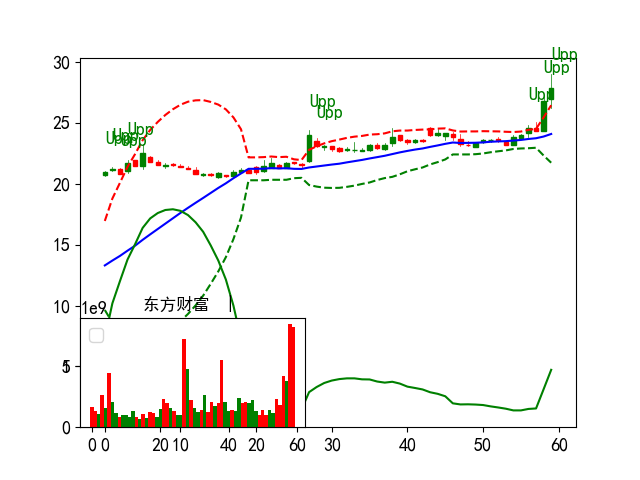

300803
xratio:0.81 ra_diff:2.18
code: 300803


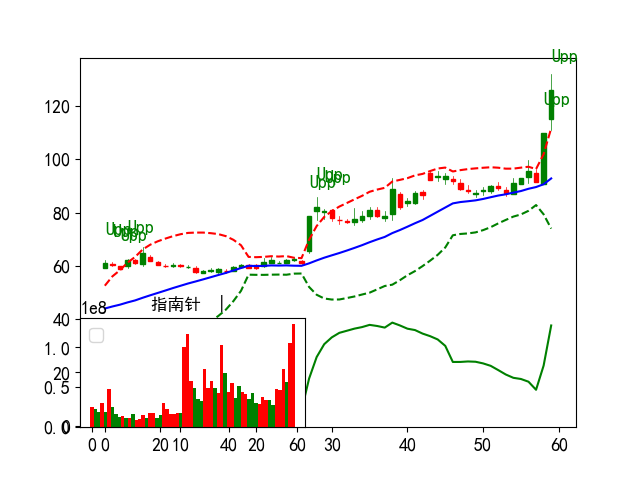

In [61]:
if top20_nd is not None:
    for co in top20_nd.index[:2]:
            print(co)
            # show_ohlc_upper(dfs.loc[co][-30:],co)
            if co in dfsRoot.index:
                show_ohlc_upper(dfsRoot.loc[co][-tail_days:],co)
            else:
                print(f'code:{co} not find in dfsRoot')

In [62]:
code_df = '600519'
dfNow_t2 = dfNow.groupby(level=[0]).tail(2)
# dfNow_f = dfNow_t2[ (dfNow_t2.idx > dfNow_t2.idx.shift(1)) & (dfNow_t2.xratio > dfNow_t2.xratio.shift(1)) ]
idx = pd.IndexSlice
mask_df =  ((dfNow_t2.idx > dfNow_t2.idx.shift(1)) & (dfNow_t2.xratio > dfNow_t2.xratio.shift(1)) )

dfNow_t2 = dfNow_t2.loc[idx[mask_df, :]]

group250 = dfNow_t2.groupby(level=[0])
dfNow_f = group250.tail(1).reset_index().set_index('code')
mask_df = (dfNow_f.date >= cct.get_today())
dfNow_f = dfNow_f.loc[idx[mask_df, :]]
dfNow_f[:2]

date   open   high    low  close        vol       amount  \
code                                                                    
688798 2025-08-18  76.81  80.69  75.44  79.12  6394050.0  500881728.0   
688788 2025-08-18  81.25  96.44  81.25  93.75  7742896.0  690336320.0   

        ra_diff   ma10    ma5  ...  perc5d  vol1d  vol2d  vol3d  vol4d  \
code                           ...                                       
688798     1.28  74.59  75.84  ...    8.01  78.29 -35.33  69.42 -17.16   
688788     2.35  79.05  81.44  ...   24.68  33.48  -6.48 -46.78  72.68   

         vol5d  volsum5d  ma51d  xratio    idx  
code                                            
688798  115.58     210.8  75.84    0.48   6.31  
688788   -8.86      44.0  81.44    2.30  15.56  

[2 rows x 32 columns]

In [63]:
# dfNow_f.shape,dfNow_f[:3],dfNow_t2.loc['600812'],df.loc['600812'][-2:]
# dfNow_f[dfNow_f.date >= cct.get_today()]
# dfNow_f.loc['000006']
# dfNow_t2.loc['000006']
# (dfNow_t2.loc[code_df].idx > dfNow_t2.loc[code_df].idx.shift(1)) 
# (dfNow_t2.loc[code_df].xratio > dfNow_t2.loc[code_df].xratio.shift(1))
# dfNow_f.loc[code_df],dfNow.loc[code_df]

### pandas multiinde drop last row

In [64]:
df.loc['000002'][-2:]

open  high   low  close          vol        amount  ra_diff
date                                                                   
2025-08-15  6.43  6.59  6.42   6.53  159536832.0  1.041381e+09     1.03
2025-08-18  6.53  6.56  6.48   6.50  138162544.0  8.988115e+08     1.02

In [65]:
dfNow.loc['000002'][-2:]

open  high   low  close          vol        amount  ra_diff  ma10  \
date                                                                            
2025-08-15  6.43  6.59  6.42   6.53  159536832.0  1.041381e+09     1.03  6.46   
2025-08-18  6.53  6.56  6.48   6.50  138162544.0  8.988115e+08     1.02  6.47   

             ma5  ma20  ...  perc5d  vol1d  vol2d  vol3d  vol4d  vol5d  \
date                    ...                                              
2025-08-15  6.47  6.54  ...    1.24  32.79  48.19  10.42 -10.66  59.79   
2025-08-18  6.48  6.53  ...    0.31 -13.40  32.79  48.19  10.42 -10.66   

            volsum5d  ma51d  xratio   idx  
date                                       
2025-08-15     140.5   6.47   -0.01  0.12  
2025-08-18      67.3   6.48   -0.01  0.05  

[2 rows x 31 columns]

# 基础处理

In [66]:
# show_tdx_data(dfs.loc['600519'][-2:])
dfs = dfNow.fillna(0)
groupd = dfs.groupby(level=[0])
single = False
dt_low = None
df_idx = None
if single:
    dfs_dtlen = groupd.tail(1)
    print("dfs tail1")
else:
    single = True
    dl = 30
    dindex = tdd.get_tdx_Exp_day_to_df(
        '999999', dl=dl, resample=resample).sort_index(ascending=False)
    dt = tdd.get_duration_price_date('999999', df=dindex)

    dt = dindex[dindex.index >= dt].index.values
    dt_low = dt[-1]
    print('dt_low:%s %s' % (dt_low,dt[0]))
    dtlen = len(dt) if len(dt) > 0 else 1
    dfs_dtlen = groupd.tail(dtlen)
    # import ipdb;ipdb.set_trace()
    dfs_dtlen[-2:]
    df_idx = get_groupby_mean_median_close(dfs_dtlen)

    # print(("dfs tail:%s dt:%s" % (dtlen, dt)))
    dfs_dtlen = get_multi_date_duration(dfs_dtlen, dt[-1])

# groupd2 = dfs.groupby(level=[0])
# dfs['ma%d'%cumdays] = groupd['close'].apply(pd.rolling_mean, cumdays)

# dfs.reset_index().groupby(['code'])['date'].transform('count')
# single = True

print("Low:%s" % (dt[-1]))
# dfs_dtlen.loc['999999'].reset_index().date
lastday_week = dfs_dtlen.loc['999999'].reset_index().date[0]
lastday_week
# dfs_dtlen[('ma%s') % (rollma[-1])][-2:]
# print(df_idx)

dt_low:2025-07-08 2025-08-18


open   high    low  close          vol        amount  \
code   date                                                                
000001 2025-08-15  12.23  12.23  11.94  12.08  194850288.0  2.344073e+09   
       2025-08-18  12.06  12.15  12.03  12.08  123905840.0  1.496527e+09   

                   ra_diff   ma10    ma5   ma20  ...  perc5d  vol1d  vol2d  \
code   date                                      ...                         
000001 2025-08-15      1.1  12.33  12.23  12.42  ...   -2.58  57.01  10.83   
       2025-08-18      1.1  12.31  12.19  12.37  ...   -1.79 -36.41  57.01   

                   vol3d  vol4d  vol5d  volsum5d  ma51d  xratio   idx  
code   date                                                            
000001 2025-08-15  64.66 -27.22  12.60     117.9  12.23   -0.03 -0.22  
       2025-08-18  10.83  64.66 -27.22      68.9  12.19   -0.03 -0.39  

[2 rows x 31 columns]

Low:2025-07-08


Timestamp('2025-07-08 00:00:00')

In [67]:
time_s = time.time()
# rollma

def get_mask_df(dfs):
    dfs = dfs.fillna(0)
    idx = pd.IndexSlice
    # mask = (dfs[('ma%s')%(rollma[0])] > dfs[('ma%s')%(rollma[1])]) & (dfs[('ma%s')%(rollma[-1])] > 0) & (dfs[('close')] > dfs[('ma%s')%(rollma[0])])  & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])])
    # mask = (dfs[('ma%s')%(rollma[0])] > dfs[('ma%s')%(rollma[1])]) & (dfs[('ma%s')%(rollma[-1])] > 0) & (dfs[('close')] > dfs[('ma%s')%(rollma[1])])  & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])])
    # mask = (dfs[('ma%s')%(rollma[0])] > dfs[('ma%s')%(rollma[1])]) & (dfs[('ma%s')%(rollma[-1])] > 0) &  (dfs[('close')] > dfs[('ma%s')%(rollma[-1])])

    # mask = ( (dfs[('ma%s')%(rollma[0])] > 0) & (dfs[('ma%s')%(rollma[-1])] > 0) & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])]) & (dfs[('close')] > dfs[('ma%s')%(rollma[0])]))
    # mask = ( (dfs[('ma%s')%(rollma[0])] > 0) & (dfs[('ma%s')%(rollma[-1])] > 0)
    #         & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])]*ma_250_l)
    #         & (dfs[('close')] < dfs[('ma%s')%(rollma[-1])]*ma_250_h)
    #         & (dfs[('close')] > dfs[('ma%s')%(rollma[0])]))

    # & (dfs['mean'] > dfs['median'])
    # & (dfs['close'] > dfs['mean'])

    if len(rollma) > 1:

        mask = ((dfs[('ma%s') % (rollma[0])] > 0) & (dfs[('ma%s') % (rollma[-1])] > 0) &
                (dfs[('ma%s') % (rollma[0])] > dfs[('ma%s') % (rollma[-1])]) &
                (dfs[('close')] > dfs[('ma%s') % (rollma[0])]) &
                (dfs[('close')] > dfs[('ma%s') % (rollma[-1])]*ma_250_h) &
                ((dfs[('close')] > dfs['boll']) | (dfs[('close')] > dfs['upper']))
                )
    else:
        mask = ((dfs[('ma%s') % (rollma[0])] > 0) &
                (dfs[('close')] > dfs[('ma%s')%(rollma[0])]) &
                ((dfs[('close')] > dfs['boll']) | (dfs[('close')] > dfs['upper']) )
                )

    return dfs.loc[idx[mask, :]]

# mask = ((dfs[('close')] > dfs[('ma%s')%(rollma[-1])]))


df_mask = get_mask_df(dfs_dtlen)
print(df_mask.shape)
df_mask = get_multi_code_count(df_mask)
print((df_mask.couts[:5], df_mask.shape))

# import ipdb;ipdb.set_trace()
# df.sort_values(by='couts',ascending=0)
# groupd.first()[:2],groupd.last()[:2]
# groupd = df250.groupby(level=[0])
# '''
# groupd.transform(lambda x: x.iloc[-1])
# groupd.last()
# groupd.apply(lambda x: x.close > x.ma250)
# df.shape,df.sort_index(ascending=False)[:5]
# ?groupd.agg
# groupd = df.groupby(level=[0])
# groupd['close'].apply(pd.rolling_mean, 250, min_periods=1)
# ex:# Group df by df.platoon, then apply a rolling mean lambda function to df.casualties
# df.groupby('Platoon')['Casualties'].apply(lambda x:x.rolling(center=False,window=2).mean())

code_uniquelist = df_mask.index.get_level_values('code').unique()
code_select = code_uniquelist[random.randint(0, len(code_uniquelist) - 1)]

# if app:
#     print(round(time.time() - time_s, 2), 's', df.index.get_level_values(
#         'code').unique().shape, code_select, df.loc[code_select][-1:])

if single:
    # groupd = df.groupby(level=[0])
    if tdx:
        # block_path = tdd.get_tdx_dir_blocknew() + '060.blk'
        # if cct.get_work_time():
        #     codew = df[df.date == cct.get_today()].index.tolist()

        if dt_low is not None:

            groupd2 = df_mask.groupby(level=[0])
            df_mask = groupd2.tail(1)
            df_mask = df_mask.reset_index().set_index('code')
            # import ipdb;ipdb.set_trace()

            # df = df[(df.date >= dt_low) & (df.date <= cct.get_today())]
            dd = df_mask[(df_mask.date == dt_low)]
            # df = df[(df_mask.date >= cct.last_tddate(1))]
            df_mask = df_mask[(df_mask.date >= df_mask.date.max())]
            # import ipdb;ipdb.set_trace()
            print(("dt_low:%s df:%s %s df_idx:%s" %
                  (dt_low,len(df_mask), df_mask.index[:5], len(df_idx))))


                
            print(("Main Down dd :%s MainUP df:%s couts std:%0.1f " %
                  (len(dd), len(df_mask), df_mask.couts.std())))
            # print df.date.mode()[0]
            if len(df_mask) > 0:
                if df_idx is not None and len(df_mask) > 0 and len(df_idx) > 0:
                    idx_set_ = [x for x in df_idx.index if x in df_mask.index]
                    # df_mask = df_mask.loc[idx_set_, :].dropna()
                df_mask = df_mask.sort_values(by='couts', ascending=1)
                df_mask = df_mask[df_mask.couts > df_mask.couts.std()]
            else:
                print("df_mask is None:%s"%(len(df_mask)))
            # df = df[(df.date >= df.date.mode()[0]) & (df.date <= cct.get_today())]
            codew = df_mask.index.tolist()

            if app:
                print(
                    "time: %s  %s" %
                    (round(time.time() - time_s, 2), len(df_mask)))

        else:
            df_mask = df_mask.reset_index().set_index('code')
            df_mask = df_mask[(df_mask.date >= cct.last_tddate(days=10)) &
                              (df_mask.date <= cct.get_today())]
            codew = df_mask.index.tolist()

        top_temp = tdd.get_sina_datadf_cnamedf(codew, df_mask)
  #      top_temp = top_temp[(~top_temp.index.str.contains(
  #          '688')) & (~top_temp.name.str.contains('ST'))]
        top_temp = top_temp.sort_values(by=['couts'], ascending=[0])
        codew = top_temp.index.tolist()

        # clean st and 688

    # df['date'] = df['date'].apply(lambda x:(x.replace('-','')))
    # df['date'] = df['date'].astype(int)
    # print df_mask.loc[code_select].T,df_mask.shape
#     MultiIndex = False
# else:
#     MultiIndex = True

(24747, 31)
count dd.couts
(code    date      
688383  2025-07-08    25
605060  2025-07-08    25
605020  2025-07-08    25
603757  2025-07-08    25
603516  2025-07-08    25
Name: couts, dtype: int64, (24747, 32))
dt_low:2025-07-08 df:1314 Index(['688383', '605060', '605020', '603757', '603516'], dtype='object', name='code') df_idx:2259
Main Down dd :1 MainUP df:1314 couts std:6.0 
time: 0.06  1194


In [68]:
dfs_dtlen.loc['002987'][-1:]

open   high    low  close          vol        amount  ra_diff  \
date                                                                         
2025-08-18  23.77  24.89  22.58  23.77  118612440.0  2.788563e+09     1.96   

             ma10    ma5  ma20  ...  perc5d  vol1d  vol2d   vol3d  vol4d  \
date                            ...                                        
2025-08-18  21.25  22.38  21.3  ...   17.91 -24.59   7.32  110.52  51.27   

            vol5d  volsum5d  ma51d  xratio   idx  
date                                              
2025-08-18  86.55     231.1  22.38   -0.11  3.58  

[1 rows x 31 columns]

## 最近60天筛选

In [69]:
# 截取最后5天数据
dfs_tail = dfs.groupby(level=[0]).tail(tail_days)
# 还原多索引
# dfs_tail = dfs_tail.reset_index().set_index(['code','date'])
# dfs_tail[dfs_tail.ra_diff > 2]

### filter mask250 get_level_values

In [70]:
mask250 = ((dfs_tail[('ma%s') % (rollma[0])] > 0) & (dfs_tail[('ma%s') % (rollma[-1])] > 0) &
           (dfs_tail[('close')] > dfs_tail[('ma%s') % (rollma[0])])
            & (dfs_tail[('close')] > dfs_tail[('ma%s') % (rollma[-1])]*1.03)
              & (dfs_tail[('close')] < dfs_tail[('ma%s') % (rollma[-1])]*1.1)
                & (dfs_tail[('close')] > dfs_tail[('ma20')])
           & (dfs_tail[('close')] < dfs_tail[('ma20'   )]*1.1))
idx = pd.IndexSlice
df_mask250 = dfs_tail.loc[idx[mask250, :]]
print(df_mask250.shape)
df_mask250 = get_multi_code_count(df_mask250)
print((df_mask250.couts[:1], df_mask250.shape))

groupd250 = df_mask250.groupby(level=[0])
df_mask250 = groupd250.tail(1)
# df_mask250 = df_mask250[df_mask250.index.get_level_values(1) > str(df_mask250.loc['999999'].index[0])[:10] ]
# df_mask250 = clean_688(df_mask250)

# df_mask250['idx'] = df_idx_detect
print((df_mask250.couts[:2], df_mask250.shape))
# print(df_mask.loc['002987'])
df_mask250 = df_mask250.sort_values(
        by=['ra_diff','hat', 'couts'],
        ascending=[0,0, 0])
show_tdx_data(df_mask250)

(1769, 31)
count dd.couts
(code    date      
002983  2025-07-01    22
Name: couts, dtype: int64, (1769, 32))
(code    date      
002983  2025-08-18    22
600235  2025-08-13    21
Name: couts, dtype: int64, (428, 32))
Count:428 32


couts  ra_diff  xratio   idx    hat  close  volsum5d  \
code   date                                                               
688382 2025-07-29      1     2.39    0.00  0.00  21.80  47.00     -34.6   
300581 2025-08-12      3     2.34    0.16  0.71   6.20  22.77       1.3   
003040 2025-07-17      3     2.21    0.00  0.00  12.76  27.52     -25.7   
002826 2025-08-13      2     2.14    0.22  0.61   7.63  22.31      39.5   
688062 2025-08-18      7     2.06    0.17  1.22   6.58  36.75      45.0   
301389 2025-07-09      1     1.96    0.00  0.00  19.67  38.00     167.8   
002199 2025-08-01      7     1.91    0.00  0.00   1.48   9.03      33.6   
301137 2025-07-08      3     1.76    0.00  0.00  12.45  38.56     -31.3   
301150 2025-08-07      1     1.71    0.00  0.00   9.37  27.81     -50.1   
300677 2025-08-18      1     1.70    0.58 -1.09  14.30  37.72      14.1   
000668 2025-08-05      6     1.68    0.00  0.00   0.73   8.58     263.1   
688553 2025-08-07      2     1.66    0.00  0.00   5.76  22.59     -42.8   
001298 2025-08-15      5     1.63    0.03  2.86   6.07  31.30     -87.6   
301227 2025-07-16      1     1.62    0.00  0.00   5.42  27.41     156.2   
301448 2025-08-15      1     1.61    0.20  3.59   5.72  31.92     128.3   
002961 2025-08-18      3     1.61   -0.01  2.40   4.36  23.67      91.0   
688300 2025-07-30      1     1.59    0.00  0.00  17.35  60.66     186.2   
002581 2025-07-08      1     1.58    0.00  0.00   3.47  10.47      85.6   
688236 2025-08-18      2     1.57    0.26  1.56   6.40  23.58      -8.0   
300095 2025-08-01      1     1.57    0.00  0.00   2.20  10.62     -36.4   

                    hmax   lmin  perc1d   ma20  ma250  vol1d   vol2d   vol3d  \
code   date                                                                    
688382 2025-07-29  49.00  30.03    5.10  45.02  44.52  58.76   -3.30  -43.44   
300581 2025-08-12  25.77  18.41   -2.73  21.60  20.95 -13.59   -6.66  -28.26   
003040 2025-07-17  29.45  17.00   -1.89  25.92  25.87 -25.01   -8.95    7.50   
002826 2025-08-13  23.91  17.72   -3.00  20.83  21.08 -39.87   11.90   97.06   
688062 2025-08-18  38.12  30.50    0.77  34.85  34.75   0.07    8.46  -35.56   
301389 2025-07-09  40.00  20.34   12.89  35.57  36.47   9.40  -13.13   27.71   
002199 2025-08-01   9.61   8.03    5.00   8.77   8.60  58.29  -28.11   19.31   
301137 2025-07-08  45.56  31.88   -3.21  37.99  36.08 -19.52   16.92   -9.93   
301150 2025-08-07  30.69  22.06   -4.73  25.48  26.18 -28.42   48.04  -32.96   
300677 2025-08-18  40.88  26.41    0.00  34.60  36.48 -30.70   70.07  -33.69   
000668 2025-08-05   8.58   7.67    5.02   8.04   7.87   8.71   76.17  -49.28   
688553 2025-08-07  24.36  17.66   -2.17  21.37  21.77 -20.13  -41.04   44.09   
001298 2025-08-15  33.91  28.05    1.26  30.20  29.00 -40.25  -16.52  -26.60   
301227 2025-07-16  28.91  20.70    2.35  25.30  26.18 -32.57  104.32  -25.19   
301448 2025-08-15  33.00  26.17    2.34  29.20  30.64 -37.15  230.63  -15.52   
002961 2025-08-18  25.88  21.00   -1.13  22.38  22.18 -26.40    2.47    6.72   
688300 2025-07-30  61.09  44.38    1.80  57.14  58.07 -49.18   90.56  178.27   
002581 2025-07-08  11.67   7.92   -4.99   9.80   9.67 -99.74   76.00  -24.94   
688236 2025-08-18  25.91  18.80   -0.80  22.38  22.89  13.96  -27.90   12.32   
300095 2025-08-01  11.39   9.18   -3.98   9.93   9.86 -37.37    9.35    6.85   

                    vol4d  vol5d  perc3d  perc5d  
code   date                                       
688382 2025-07-29  -24.61 -21.98    3.30   17.50  
300581 2025-08-12  -25.13  74.94   -2.15    4.26  
003040 2025-07-17    4.09  -3.33   11.42    8.52  
002826 2025-08-13  -12.02 -17.62    7.62    3.33  
688062 2025-08-18   46.64  25.42    2.62    8.70  
301389 2025-07-09   90.99  52.88   19.05   52.73  
002199 2025-08-01    6.46 -22.38    0.56    2.03  
301137 2025-07-08  -37.34  18.62    0.00    2.74  
301150 2025-08-07   -6.92 -29.82   -4.30   -2.63  
300677 2025-08-18  -19.20  27.59    3.88    0.

#### filter today

In [71]:
df_mask250  = df_mask250[(df_mask250.xratio > 0) & (df_mask250.index.get_level_values('date') > cct.get_today() )]
# df_tail1[df_tail1.index.get_level_values('date') == cct.get_today()].shape


In [72]:
# df_mask250.index.get_level_values(1) > str(df_mask250.loc['999999'].index[0])[:10]

#### debug ra_diff4

In [73]:
dfs.loc['301073'][-5:].ra_diff

date
2025-08-11    1.10
2025-08-12    1.11
2025-08-14    1.12
2025-08-15    1.13
2025-08-18    1.14
Name: ra_diff, dtype: float64

xratio:-0.01 ra_diff:1.02
code: 000002


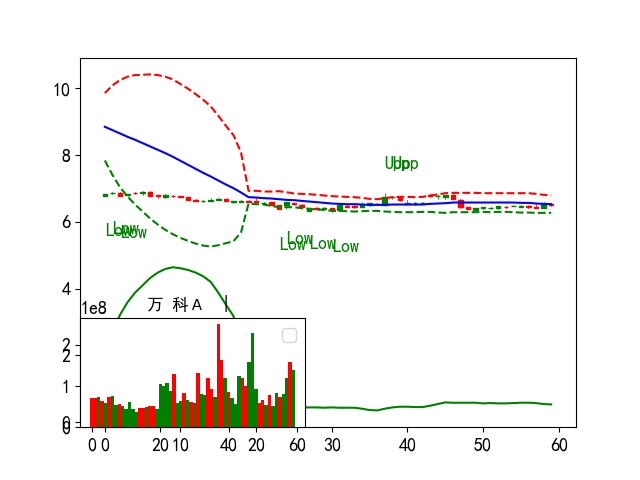

In [74]:
# dfs.loc['000002'][-60:]
show_ohlc_upper(dfsRoot.loc['000002'][-60:],code='000002')
for co in df_mask250.index.get_level_values(0)[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-tail_days:],code=co)

## 最近60天数据

In [75]:
dfs_tail9 = dfs.groupby(level=[0]).tail(tail_days)

# 提取倒数第二天
# dfs_tail9 = dfs.groupby(level=[0]).tail(6)
# dfs_tail9 = dfs_tail9[dfs_tail9.index.get_level_values(1) <lastday]


# dfs_tail9.index.get_level_values(0)
# 还原多索引
# dfs_tail = dfs_tail.reset_index().set_index(['code','date'])
# print(dfs_tail9.loc['002987'][:1])
# show_tdx_data(dfs_tail9.loc[code_t])
# dfs_tail9=compute_perd_value(dfs_tail9,market_value=5,col='vol')

# show_tdx_data(dfs_tail9.loc[code_t])
# print((dfs_tail9.loc[code_t]))

In [76]:
dfs_tail9.loc[(['999999','399001','399006'],'ra_diff')].groupby(level=0).tail(3)
# dfs_tail9.loc[pd.IndexSlice[['999999','399001','399006'], :, :]].tail(3)
# dfs_tail9.query(("code == '999999'" and "date > '2023-04-01'"))

code    date      
999999  2025-08-14    1.10
        2025-08-15    1.11
        2025-08-18    1.12
399001  2025-08-14    1.14
        2025-08-15    1.16
        2025-08-18    1.18
399006  2025-08-14    1.24
        2025-08-15    1.27
        2025-08-18    1.31
Name: ra_diff, dtype: float64

## 超跌反弹年线大于MA20

In [77]:
# show_tdx_data(dfs_tail9.loc['300418'])[-2:]
show_tdx_data(dfs_tail9.loc['603131'])
# print(dfs_tail9.loc['603131',['high','upper','hmax']])

Count:30 31


ra_diff  xratio  idx   hat  close  volsum5d   hmax   lmin  perc1d  \
date                                                                            
2025-07-01     1.07     0.0  0.0  1.79  17.55     138.5  18.61  16.39   25.72   
2025-07-02     1.07     0.0  0.0  1.69  17.56     128.6  18.61  16.39    0.06   
2025-07-03     1.12     0.0  0.0  1.74  18.44     571.2  19.31  16.39    5.01   
2025-07-04     1.09     0.0  0.0  1.59  17.88     521.8  19.31  16.47   -3.04   
2025-07-07     1.10     0.0  0.0  1.55  18.06     358.9  19.31  16.64    1.01   
2025-07-08     1.10     0.0  0.0  1.57  18.16     373.8  19.31  16.91    0.55   
2025-07-09     1.09     0.0  0.0  1.53  17.91     323.0  19.31  16.91   -1.38   
2025-07-10     1.08     0.0  0.0  1.50  17.80    -132.5  19.31  16.91   -0.61   
2025-07-11     1.08     0.0  0.0  1.43  17.81    -114.4  19.31  16.91    0.06   
2025-07-14     1.09     0.0  0.0  1.42  17.91     -72.4  19.31  16.91    0.56   
2025-07-16     1.05     0.0  0.0  1.44  17.33     -82.3  19.31  16.91   -3.24   
2025-07-17     1.06     0.0  0.0  1.45  17.48     -62.7  19.31  16.91    0.87   
2025-07-18     1.06     0.0  0.0  1.45  17.42     -53.8  19.31  16.91   -0.34   
2025-07-25     1.09     0.0  0.0  1.34  17.91      12.4  19.31  16.91    2.81   
2025-07-28     1.10     0.0  0.0  1.27  18.14      56.2  19.31  17.00    1.28   
2025-07-29     1.10     0.0  0.0  1.26  18.08      69.3  19.31  17.09   -0.33   
2025-07-30     1.11     0.0  0.0  1.23  18.17     167.5  19.31  17.19    0.50   
2025-07-31     1.11     0.0  0.0  1.23  18.17     170.6  19.31  17.19    0.00   
2025-08-01     1.09     0.0  0.0  1.17  17.91      97.4  19.31  17.19   -1.43   
2025-08-04     1.12     0.0  0.0  1.27  18.45      98.6  19.31  17.19    3.02   

             ma20  ma250   vol1d   vol2d   vol3d   vol4d   vol5d  perc3d  \
date                                                                       
2025-07-01  13.45  12.85  -24.61  118.69    9.54   -8.36   43.25   30.29   
2025-07-02  13.69  12.86   33.37  -24.61  118.69    9.54   -8.36   28.36   
2025-07-03  13.97  12.88  434.17   33.37  -24.61  118.69    9.54   32.09   
2025-07-04  14.20  12.90  -39.83  434.17   33.37  -24.61  118.69    1.88   
2025-07-07  14.45  12.92  -44.24  -39.83  434.17   33.37  -24.61    2.85   
2025-07-08  14.70  12.94   -9.63  -44.24  -39.83  434.17   33.37   -1.52   
2025-07-09  14.94  12.95  -17.46   -9.63  -44.24  -39.83  434.17    0.17   
2025-07-10  15.20  12.97  -21.37  -17.46   -9.63  -44.24  -39.83   -1.44   
2025-07-11  15.45  12.98  -21.67  -21.37  -17.46   -9.63  -44.24   -1.93   
2025-07-14  15.69  13.00   -2.24  -21.67  -21.37  -17.46   -9.63    0.00   
2025-07-16  15.90  13.01  -19.53   -2.24  -21.67  -21.37  -17.46   -2.64   
2025-07-17  16.12  13.02    2.12  -19.53   -2.24  -21.67  -21.37   -1.85   
2025-07-18  16.32  13.03  -12.50    2.12  -19.53   -2.24  -21.67   -2.74   
2025-07-25  16.54  13.04   44.52  -12.50    2.12  -19.53   -2.24    3.35   
2025-07-28  16.78  13.05   41.62   44.52  -12.50    2.12  -19.53    3.78   
2025-07-29  17.01  13.07   -6.44   41.62   44.52  -12.50    2.12    3.79   
2025-07-30  17.24  13.08  100.26   -6.44   41.62   44.52  -12.50    1.45   
2025-07-31  17.47  13.09   -9.41  100.26   -6.44   41.62   44.52    0.17   
2025-08-01  17.68  13.10  -28.65   -9.41  100.26   -6.44   41.62   -0.94   
2025-08-04  17.91  13.11   42.81  -28.65   -9.41  100.26   -6.44    1.54   

            perc5d  
date                
2025-07-01   30.58  
2025-07-02   28.55  
2025-07-03   36.90  
2025-07-04   30.70  
2025-07-07   29.37  
2025-07-08    3.48  
2025-07-09    1.99  
2025-07-10   -3.47  
2025-07-11   -0.39  
2025-07-14   -0.83  
2025-07-16   -4.57  
2025-07-17   -2.40  
2025-07-18   -2.13  
2025-07-25    0.56  
2025-07-28    1.28  
2025-07-29    4.33  
2025-07-30    3.95  
2025-07-31    4.31  
2025-08-01    0.00  
2025-08-04    1.71

## !!! Run-Filter强势Upper

### !!! filterRule test

In [78]:
# dfs_tail9.loc['002722']


def rules_to_list(rules):
    rules_l = (rules).split('&')
    for l in rules_l:
        print(l)
    return rules_l


def filter_rule_Test(dfs_tail9,resample=resample):
    col_rule = ["(dfs_tail9[('close')] > dfs_tail9[('ma5')])",
                "(dfs_tail9[('high')] > dfs_tail9.upper)",
                "(dfs_tail9[('ma5')] > dfs_tail9[('ma20')])"]
    col_rule2 = [
        "(dfs_tail9[('close')] > dfs_tail9[('hmax')].shift(1)*0.98) | (dfs_tail9['close'] > dfs_tail9['hmax']*0.97)",
        "((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))"]
    col_rule3 = [
        "((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))"]

    col_rule_tail1 = ["(dfs_tail9.perc1d < 21)", "(dfs_tail9.perc2d > 0)"]
    if resample.upper()=='D':
        col_rule_tail2 = [
            "((dfs_tail9.perc3d > 0) | ((dfs_tail9.close.shift(2) > dfs_tail9.ma5.shift(2))) )",
            "((dfs_tail9.volsum5d > 50) )",
            "(dfs_tail9['close'] > dfs_tail9[('hmax')])",
            "(dfs_tail9[('close')] > dfs_tail9[('ma250')])",
            "(dfs_tail9['low'] > dfs_tail9[('low')].shift(1))"]
        col_rule_tail3 = ["(dfs_tail9[('hmax')] > 0)",
                 "(dfs_tail9[('high')] >= dfs_tail9[('hmax')])",
                 "(dfs_tail9[('close')] > dfs_tail9.ma250 * 0.99)"]
    else:
        col_rule_tail2 = [
            "((dfs_tail9.perc3d > 0) | ((dfs_tail9.close.shift(2) > dfs_tail9.ma5.shift(2))) )",
            "((dfs_tail9.volsum5d > 50) )",
            "(dfs_tail9['close'] > dfs_tail9[('hmax')])",
            "(dfs_tail9['low'] > dfs_tail9[('low')].shift(1))"]
        col_rule_tail3 = ["(dfs_tail9[('hmax')] > 0)",
                 "(dfs_tail9[('high')] >= dfs_tail9[('hmax')])"]
    col_rule_tail4=[ "(dfs_tail9[('xratio')] > dfs_tail9[('xratio')].shift(1))",
             "(dfs_tail9[('xratio')].shift(1) > dfs_tail9[('xratio')].shift(2))"]
    
    col_rule.extend(col_rule2)
    col_rule.extend(col_rule3)
    col_rule.extend(col_rule_tail1)
    col_rule.extend(col_rule_tail2)
    col_rule.extend(col_rule_tail3)
    col_rule.extend(col_rule_tail4)
    
    for co in col_rule:
        print("%s:%s" % (co, eval(co)), end='')



30
9 0.01 0.06


'Bull'

0.06

date
2025-08-12   -0.02
2025-08-13   -0.02
2025-08-14   -0.01
2025-08-15   -0.01
2025-08-18   -0.01
Name: xratio, dtype: float64

xratio:-0.01 ra_diff:1.02
code: 601728


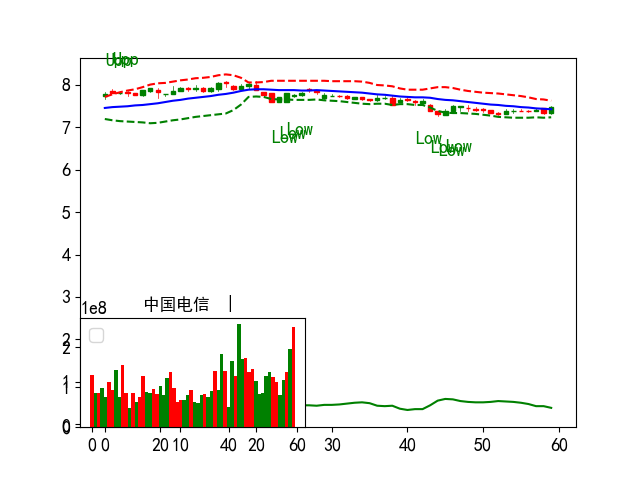

In [79]:
code_filter = '601728'

print(len(dfs_tail9.loc[code_filter]))

# show_tdx_data(dfs_tail9.loc[code_filter])
detect_bull_bear(dfs.loc[code_filter][-120:].close)
detect_bull_bear_apply(dfs.loc[code_filter][-120:].close)

dfs.loc[code_filter].xratio[-5:]

# filter_rule_Test(dfs_tail9.loc[code_filter])

show_ohlc_upper(dfsRoot.loc[code_filter][-60:], code=code_filter)



In [80]:
# dfs.loc['300474'][-5:]

### 新高Hmax日见新高df_mask_hmax

#### hmax 追高 TEST

In [81]:
code='600012'
print(len(dfs_tail9.loc[code]))
# show_tdx_data(dfs_tail9.loc[code],col='upper')
show_ohlc_upper(dfsRoot.loc[code],code=code)

30
xratio:-0.03 ra_diff:1.0
code: 600012


In [82]:

# mask_hmax = ((dfs_tail9[('close')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['close'] > dfs_tail9['hmax'] * 0.99))

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & ((dfs_tail9[('high')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['high'] > dfs_tail9['hmax'] * 0.99)) )

# mask_hmax = ((dfs_tail9[('hmax')] > 0) &

if resample.upper() =='D':
    mask_hmax = ( (dfs_tail9[('high')] > dfs_tail9[('hmax')].shift(1)) &
                 ((dfs_tail9[('high')] >= dfs_tail9[('hmax')])) &
                 (dfs_tail9[('close')] > dfs_tail9.ma250 * 0.99))
                 # (dfs_tail9[('close')] > dfs_tail9.ma250 * 0.99) &
                 # (dfs_tail9[('close')] < dfs_tail9.ma250 * 1.05))
else:
    mask_hmax = ( (dfs_tail9[('low')] >= dfs_tail9[('ma5')].shift(1))  &
              (dfs_tail9[('high')] >= dfs_tail9[('high')].shift(1))  ) 

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & (dfs_tail9[('close')] > dfs_tail9.ma20 *0.99) & (dfs_tail9[('close')] < dfs_tail9.ma20 *1.20) )


df_mask_hmax = dfs_tail9.loc[idx[mask_hmax, :]]
df_mask_hmax = get_multi_code_count(df_mask_hmax)

# df_mask_hmax = df_mask_hmax[ (df_mask_hmax[('close')] > df_mask_hmax.upper)]

# df_mask_hmax.couts.std()

df_mask_hmax = df_mask_hmax.groupby(level=[0]).tail(
    1).reset_index().set_index('code')

df_mask_hmax = df_mask_hmax[df_mask_hmax.date >= lastday]
# df_mask_hmax = get_sina_data_cname(df_mask_hmax, dm,realtime=True)
df_mask_hmax = get_sina_data_cname(df_mask_hmax, realtime=True)

df_mask_hmax = clean_688(df_mask_hmax)

# show_tdx_data(df_mask_hmax[df_mask_hmax.couts == 9])

# by=['perc', 'perc5d', 'perc1d'],
# code_t = '000534'
df_mask_hmax = df_mask_hmax.sort_values(
    by=['couts','volsum5d', 'idx', 'hat', 'perc1d'],ascending=[0,0, 0, 0, 0])
    # by=['volsum5d', 'idx', 'hat', 'perc1d'],ascending=[0, 0, 0, 0])
# print(df_mask_hmax.couts[:1], df_mask_hmax.shape)
# show_tdx_data(df_mask_hmax.loc['300461'])
df_mask_hmax.couts[:1], df_mask_hmax.shape
show_tdx_data(df_mask_hmax)
# show_tdx_data(df_mask_hmax[(df_mask_hmax.couts > 1) & (df_mask_hmax.volsum5d > 10) & (df_mask_hmax.volsum5d < 150)]).T

count dd.couts
compute percent


(code
 603516    22
 Name: couts, dtype: int64,
 (554, 41))

Count:554 41


name  couts       date   perc  ra_diff  xratio     idx      hat  \
code                                                                      
603516  淳中科技     22 2025-08-18   9.98     3.82    3.81   54.00   103.98   
002768  国恩股份     20 2025-08-18   7.47     1.95    0.61   11.53    16.24   
300436   广生堂     19 2025-08-18   2.99     6.01    4.70   48.69   120.42   
399001   NaN     19 2025-08-18    NaN     1.18   40.95  728.00  1067.88   
601208  东材科技     17 2025-08-18   2.76     2.20    0.27    3.33     6.22   
301489  思泉新材     17 2025-08-18   3.72     3.25    5.37   42.38   144.43   
603757  大元泵业     16 2025-08-18  10.02     2.42    1.01   23.81    34.30   
300395   菲利华     16 2025-08-18   3.21     2.39    1.69   24.56    42.44   
300476  胜宏科技     16 2025-08-18   0.43     3.06    3.85   42.25    96.85   
300684  中石科技     16 2025-08-18   8.70     1.70    0.46    7.17    12.75   
002245  蔚蓝锂芯     16 2025-08-18   0.05     1.59    0.22    3.21     6.34   
002837   英维克     16 2025-08-18  10.00     2.89    1.50   29.19    45.24   
300866  安克创新     16 2025-08-18   5.14     1.69    1.11   23.25    31.37   
002536  飞龙股份     16 2025-08-18  10.03     2.40    0.61   14.78    19.77   
002396  星网锐捷     15 2025-08-18   7.66     1.65    0.31    3.90     6.90   
300049  福瑞股份     15 2025-08-18  20.00     2.02    0.76   16.35    19.69   
600183  生益科技     15 2025-08-18  -0.33     1.76    0.42    4.25     9.82   
999999   NaN     15 2025-08-18    NaN     1.12    9.09  110.00   237.40   
300502   新易盛     15 2025-08-18   4.72     2.80    3.92   61.75    89.70   
399006   NaN     15 2025-08-18    NaN     1.31   13.61  262.00   364.92   

           close  volsum5d  ...    ma250  nclose      llow   vol1d   vol2d  \
code                        ...                                              
603516    126.69      -4.7  ...    21.40  125.81    116.00  -13.89  -25.49   
002768     49.03      50.3  ...    17.07   47.38     45.22   19.88   32.26   
300436    172.25      -1.4  ...    26.51  166.75    157.88  -12.28   22.78   
399001  11832.00    -592.4  ...  3072.64     NaN  11640.00 -184.39 -290.02   
601208     19.75     119.3  ...     9.69   19.38     18.31   56.96  -32.83   
301489    170.50       6.5  ...    57.57  168.75    158.00   -2.56   25.72   
603757     51.84     582.3  ...    15.58   50.31     48.00   54.84  583.40   
300395    102.50     115.1  ...    26.59  100.38     95.88  -10.98    2.72   
300476    231.75      36.6  ...    42.20  233.88    222.00   61.27  -20.99   
300684     37.09      28.8  ...    22.13   36.59     34.44   10.21   39.43   
002245     18.78      21.6  ...     9.95   18.95     18.72   -0.80   10.06   
002837     70.19       0.6  ...    18.30   68.69     63.38    2.35    4.88   
300866    148.25      -8.8  ...    50.13  145.88    140.62    8.49   55.47   
002536     32.59     -16.7  ...     9.97   32.47     30.50  -30.69   27.80   
002396     31.20     197.4  ...    10.90   31.47     29.06  139.29  -11.88   
300049     60.19     161.2  ...    14.90   60.12     55.16  141.09   -1.14   
600183     44.69     142.3  ...    14.87   45.12     44.25    5.24   56.26   
999999   3728.00      36.4  ...     0.00     NaN   3702.00   14.37    4.74   
300502    244.25      29.0  ...    47.85  243.38    227.88   24.61  -10.96   
399006   2606.00    -377.7  ...   530.96     NaN   2530.00 -186.03  174.18   

         vol3d   vol4d   vol5d  perc3d  perc5d  
code                                            
603516   75.82  -30.18  -10.97   23.83   32.83  
002768  -23.27   56.20  -34.75   15.61   20.88  
300436    5.10    2.18  -19.21   25.84   29.76  
399001 -143.89   -0.05   25.90    2.42    4.82  
601208   -1.45  104.76   -8.15   10.27   19.55  
301489   -6.61   -9.68   -0.37    8.17   15.69  
603757   64.73  -69.94  -50.76   33.13   61.04  
300395  -37.95  175.81  -14.46   12.40   35.65  
300476  -13.77    4.29    5.76   -2.63   14.44  
300684  -32.40   -0.02   11.59    9.80   15.58  
002245   -4.63   56.86  -39.87    6.34   12.25  
002

#### !!! hmax Top upper > 1

In [83]:
# dfs_tail9.loc['600103']

In [84]:
# mask_hmax = ((dfs_tail9[('close')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['close'] > dfs_tail9['hmax'] * 0.99))

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & ((dfs_tail9[('high')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['high'] > dfs_tail9['hmax'] * 0.99)) )

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & ((dfs_tail9[('high')] >= dfs_tail9[('hmax')]*0.99) ) )
# mask_hmax = (  (dfs_tail9[('high')] >= dfs_tail9[('hmax')]*0.99) )
if resample.upper() == 'D':
    mask_hmax = (  (dfs_tail9[('high')] >= dfs_tail9[('high')].shift(1)) & 
                 (dfs_tail9[('high')].shift(1) >= dfs_tail9[('high')].shift(2)) &
                (dfs_tail9[('high')] >= dfs_tail9[('hmax')]*0.99) &
                (dfs_tail9[('close')] >= dfs_tail9[('upper')].shift(1)) )
else:
    mask_hmax = (  (dfs_tail9[('high')] >= dfs_tail9[('high')].shift(1)) & 
                 (dfs_tail9[('high')].shift(1) >= dfs_tail9[('high')].shift(2)) &
                (dfs_tail9[('close')] >= dfs_tail9[('upper')].shift(1)) )

df_mask_hmax = dfs_tail9.loc[idx[mask_hmax, :]]

#站上Upper
# df_mask_hmax = df_mask_hmax[ (df_mask_hmax[('close')] > df_mask_hmax.upper)]

df_mask_hmax = get_multi_code_count(df_mask_hmax)
df_mask_hmax = df_mask_hmax.groupby(level=[0]).tail(
    1).reset_index().set_index('code')



df_mask_hmax = df_mask_hmax[df_mask_hmax.date >= lastday]
# df_mask_hmax = get_sina_data_cname(df_mask_hmax, dm,realtime=True)
df_mask_hmax = get_sina_data_cname(df_mask_hmax, realtime=True)

df_mask_hmax = clean_688(df_mask_hmax)

# show_tdx_data(df_mask_hmax[df_mask_hmax.couts == 9])

# by=['perc', 'perc5d', 'perc1d'],
# code_t = '000534'
df_mask_hmax = df_mask_hmax.sort_values(
    by=['couts', 'idx', 'hat', 'perc1d'],
    ascending=[0, 0, 0, 0])
 # by=['volsum5d', 'idx', 'hat', 'perc1d'],
print(df_mask_hmax.couts[:1], df_mask_hmax.shape)
# show_tdx_data(df_mask_hmax.loc['000039'])
df_mask_hmax.couts[:1], df_mask_hmax.shape

# show_tdx_data(df_mask_hmax).T
# show_tdx_data(df_mask_hmax[(df_mask_hmax.couts > 1) & (df_mask_hmax.volsum5d > 10) & (df_mask_hmax.volsum5d < 150)])
show_tdx_data(df_mask_hmax.query('couts >= 1 and perc >2  and   low < ma5 '),limit=10 )

count dd.couts
compute percent
code
603516    19
Name: couts, dtype: int64 (452, 41)


(code
 603516    19
 Name: couts, dtype: int64,
 (452, 41))

Count:49 41


name  couts       date   perc  ra_diff  xratio    idx    hat   close  \
code                                                                            
300510   金冠股份     11 2025-08-18   4.27     1.55    0.06   0.88   1.84    6.11   
300731   科创新源     10 2025-08-18  15.04     2.57    1.38  20.22  42.26   59.50   
002534   西子洁能     10 2025-08-18   6.03     1.45    0.17   2.86   4.89   16.00   
300866   安克创新      9 2025-08-18   5.14     1.69    1.11  23.25  31.37  148.25   
300602    飞荣达      9 2025-08-18  15.07     1.91    0.42   7.89  13.14   34.59   
002168  *ST惠程      9 2025-08-18   3.24     1.87    0.04   0.59   1.30    4.46   
600513   联环药业      8 2025-08-18   4.28     3.13    0.60   6.26  15.17   27.78   
603500   祥和实业      8 2025-08-18   2.55     1.41    0.12   2.23   3.97   12.05   
300486   东杰智能      8 2025-08-18  16.39     3.38    0.61   2.05  17.34   22.44   
300990   同飞股份      7 2025-08-18  10.23     1.76    1.06  15.35  28.90   77.44   

        volsum5d  ...  ma250  nclose    llow  vol1d  vol2d  vol3d  vol4d  \
code              ...                                                      
300510      -6.4  ...   7.35    6.06    5.83  31.81  -5.51  -8.32 -39.94   
300731      19.9  ...  20.64   56.53   49.50  11.88  25.98 -18.65  15.32   
002534      44.6  ...  10.25   15.41   14.51  76.43   7.48  -4.20   2.14   
300866      -8.8  ...  50.13  145.88  140.62   8.49  55.47 -15.08 -48.78   
300602      47.4  ...  23.03   32.66   29.91  30.54  34.22 -21.73 -31.34   
002168      17.8  ...   7.19    4.38    4.22  27.68 -21.06  63.34 -41.20   
600513      -7.4  ...  63.67   26.80   26.23   0.60  20.77 -24.87  -4.71   
603500     -59.3  ...  41.53   12.12   11.63  21.24  -3.85 -32.17 -27.29   
300486      18.1  ...  33.21   20.67   18.70  17.14  -5.90 -21.01  35.96   
300990      64.6  ...  28.96   74.81   69.31  28.18  17.65 -18.94 -16.73   

        vol5d  perc3d  perc5d  
code                           
300510  15.58    5.53    6.08  
300731 -14.64   13.74   14.07  
002534 -37.24   11.27   10.12  
300866  -8.93    7.43    9.41  
300602  35.67   16.27   22.53  
002168 -10.95    7.99    7.21  
600513   0.80    6.60   15.89  
603500 -17.25    4.42    8.46  
300486  -8.04   24.67   37.84  
300990  54.47   11.12   22.69  

[10 rows x 24 columns]

In [85]:
# show_tdx_data(df_mask_hmax.loc['600103'][-5:])

##### sort_values

In [86]:
show_tdx_data(
    df_mask_hmax.query('perc > 1').sort_values(
        by=['ra_diff', 'couts', 'idx'],
        ascending=[0, 0, 0]),col='ra_diff')

Count:337 41


name  couts       date   perc  ra_diff  ra_diff  xratio    idx  \
code                                                                      
300436    广生堂      9 2025-08-18   2.99     6.01     6.01    4.70  48.69   
002104   恒宝股份      4 2025-08-18   5.10     4.28     4.28    0.14  11.36   
603516   淳中科技     19 2025-08-18   9.98     3.82     3.82    3.81  54.00   
603256   宏和科技      7 2025-08-18   7.97     3.78     3.78    0.43  11.23   
300486   东杰智能      8 2025-08-18  16.39     3.38     3.38    0.61   2.05   
301217   铜冠铜箔      6 2025-08-18   3.79     3.25     3.25    0.48   8.74   
600513   联环药业      8 2025-08-18   4.28     3.13     3.13    0.60   6.26   
002305  *ST南置     14 2025-08-18   5.06     3.07     3.07    0.08   1.26   
002837    英维克     11 2025-08-18  10.00     2.89     2.89    1.50  29.19   
300731   科创新源     10 2025-08-18  15.04     2.57     2.57    1.38  20.22   
601929   吉视传媒     11 2025-08-18   9.95     2.44     2.44    0.09   2.09   
603757   大元泵业     12 2025-08-18  10.02     2.42     2.42    1.01  23.81   
002536   飞龙股份     12 2025-08-18  10.03     2.40     2.40    0.61  14.78   
301076   新瀚新材      5 2025-08-18  10.14     2.40     2.40    1.20  31.86   
300395    菲利华     10 2025-08-18   3.21     2.39     2.39    1.69  24.56   
600110   诺德股份      2 2025-08-18  10.00     2.38     2.38    0.05   1.33   
301123   奕东电子      6 2025-08-18  19.97     2.34     2.34    0.64  16.69   
002080   中材科技      6 2025-08-18   4.69     2.34     2.34    0.24   6.44   
300609   汇纳科技      7 2025-08-18  13.39     2.33     2.33    0.82  12.38   
600410   华胜天成     10 2025-08-18  10.05     2.30     2.30    0.39   9.39   

           hat   close  ...  ma250  nclose    llow   vol1d   vol2d   vol3d  \
code                    ...                                                  
300436  120.42  172.25  ...  26.51  166.75  157.88  -12.28   22.78    5.10   
002104   13.69   30.50  ...   9.93   30.53   26.91   -7.11   55.29  -30.69   
603516  103.98  126.69  ...  21.40  125.81  116.00  -13.89  -25.49   75.82   
603256   15.71   35.50  ...  40.36   36.03   33.81   52.24  -13.35  -33.58   
300486   17.34   22.44  ...  33.21   20.67   18.70   17.14   -5.90  -21.01   
301217   14.56   33.38  ...  36.22   33.09   31.20   -4.34   17.22  -17.97   
600513   15.17   27.78  ...  63.67   26.80   26.23    0.60   20.77  -24.87   
002305    2.30    4.36  ...  16.43    4.35    4.20  -53.56   28.21  -21.97   
002837   45.24   70.19  ...  18.30   68.69   63.38    2.35    4.88    6.45   
300731   42.26   59.50  ...  20.64   56.53   49.50   11.88   25.98  -18.65   
601929    3.18    4.31  ...   5.90    4.29    3.92   -9.64  -10.13  173.09   
603757   34.30   51.84  ...  15.58   50.31   48.00   54.84  583.40   64.73   
002536   19.77   32.59  ...   9.97   32.47   30.50  -30.69   27.80   15.58   
301076   42.93   62.81  ...  27.03   58.56   55.00    5.94   -5.87   16.37   
300395   42.44  102.50  ...  26.59  100.38   95.88  -10.98    2.72  -37.95   
600110    1.99    7.70  ...  19.20    7.70    7.44  -52.74  -18.12   20.65   
301123   23.58   47.28  ...  18.95   46.91   42.88  -15.58   19.59   67.59   
002080    8.20   33.50  ...   8.95   33.72   32.75  209.32  -56.33  -12.50   
300609   23.32   59.88  ...  22.86   60.31   53.97   16.56  -23.38  264.35   
600410   12.92   20.69  ...  20.67   20.67   19.48  -63.93   30.05  -34.05   

         vol4d  vol5d  perc3d  perc5d  
code                                   
300436    2.18 -19.21   25.84   29.76  
002104    8.76  13.81   24.19   50.25  
603516  -30.18 -10.97   23.83   32.83  
603256   45.52 -11.90   30.71   41.55  
300486   35.96  -8.04   24.67   37.84  
301217   51.06 -10.77   11.56   31.52  
600513   -4.71   0.80    6.60   15.89  
002305   19.25  28.23   15.96   27.86  
002837   -3.04 -10.06   23.14   40.21  
300731   15.32 -14.64   13.74   14.07  
601929  -28.54  27.41   19.72   45.12  
603757  -69.94 -50.76   33.13   61.04  
002536   -9.96 -19.45   33.13   42.56  
301076  -24.20  35.08   31.62   44.69  
3

xratio:-0.1 ra_diff:1.11
code: 300540


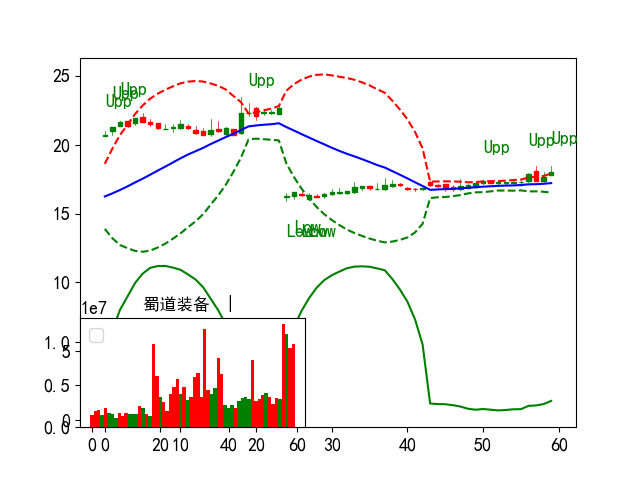

In [87]:
show_ohlc_upper(dfsRoot.loc['300540'][-60:],code='300540')

### !!! df_mask250 upper xratio

In [88]:

if resample.upper() =='D':
    mask250 = ((dfs_tail9[('high')] > dfs_tail9.upper) &
               (dfs_tail9[('close')] > dfs_tail9[('ma5')])
               & (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift( 1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['close'] > dfs_tail9[('hmax')]) &
                (dfs_tail9[('close')] > dfs_tail9[('ma250')]) | ((dfs_tail9[('high')] > dfs_tail9.upper) &
                                                                 (dfs_tail9[('close')] > dfs_tail9[('ma5')])) &
               (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['low'] > dfs_tail9[('low')].shift(1))
               & (dfs_tail9[('close')] > dfs_tail9[('ma250')])
               & (dfs_tail9[('xratio')] > dfs_tail9[('xratio')].shift(1))
               & (dfs_tail9[('xratio')].shift(1) > dfs_tail9[('xratio')].shift(2))
              )
elif resample.upper() =='W' or resample == 'W-FRI':
    mask250 = (
               (dfs_tail9[('close')] > dfs_tail9[('ma5')])
               & (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['low'] > dfs_tail9[('low')].shift(1))
               & (dfs_tail9[('xratio')] > dfs_tail9[('xratio')].shift(1))
               & (dfs_tail9[('xratio')].shift(1) > dfs_tail9[('xratio')].shift(2))
              )
else:
    mask250 = (
               (dfs_tail9[('close')] > dfs_tail9[('ma5')])
               & (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['low'] > dfs_tail9[('low')].shift(1))
              )

# & (dfs_tail9[('close')] < dfs_tail9[('ma20'  )]*1.1))
idx = pd.IndexSlice
df_mask250 = dfs_tail9.loc[idx[mask250, :]]
df_mask250.shape
#站上Upper
df_mask250 = df_mask250[ (df_mask250[('close')] > df_mask250.upper)]

df_mask250 = get_multi_code_count(df_mask250)


code_t = '603131'
print((df_mask250.couts[:3], df_mask250.shape))
# df_mask250.loc[code_t]
groupd250 = df_mask250.groupby(level=[0])
df_mask250 = groupd250.tail(1).reset_index().set_index('code')
# df_mask250 = get_sina_data_cname(df_mask250, dm,realtime=True)



# df_mask250.loc[code_t].close
df_mask250 = get_sina_data_cname(df_mask250, realtime=True)
# df_mask250.loc[code_t].close

df_mask250 = clean_688(df_mask250)
# df_masklastd.loc['002722']

df_mask250 = df_mask250.sort_values(
    by=['idx','xratio',  'hat', 'perc1d'],
    ascending=[0, 0, 0, 0])
    # by=['xratio', 'idx', 'hat', 'perc1d'],

# by=['perc', 'perc5d', 'perc1d'],
# ascending=[0, 0, 0])
print("df_mask250:%s df_mask_hmax:%s"%(len(df_mask250),len(df_mask_hmax)))
cross_hmax_250 = [co for co in df_mask250.index.get_level_values(
    'code') if co in df_mask_hmax.index.get_level_values('code')]
# df_mask250.loc[code_t]
print("cross_hamx:%s" % (len(cross_hmax_250)))
show_tdx_data(df_mask250.loc[cross_hmax_250].query('couts > 1 and perc > 0'))
# show_tdx_data(df_mask250.query('couts > 1 and perc > 0')[:20])
# show_tdx_data(df_mask250.loc[code_t])

(1419, 31)

count dd.couts
(code    date      
688401  2025-08-11    6
603757  2025-08-11    6
600737  2025-08-11    6
Name: couts, dtype: int64, (1008, 32))
compute percent
df_mask250:475 df_mask_hmax:452
cross_hamx:174
Count:91 41


name  couts       date   perc  ra_diff  xratio     idx     hat  \
code                                                                     
300033   同花顺      3 2025-08-18  10.28     1.64    3.14  116.50  128.70   
300870   欧陆通      6 2025-08-18   0.20     2.47    3.92  108.88  150.25   
301076  新瀚新材      2 2025-08-18  10.14     2.40    1.20   31.86   42.93   
301326  捷邦科技      3 2025-08-18   8.54     1.89    1.41   30.94   46.74   
002837   英维克      6 2025-08-18  10.00     2.89    1.50   29.19   45.24   
301018  申菱环境      3 2025-08-18  14.44     2.22    1.14   27.10   36.02   
603757  大元泵业      6 2025-08-18  10.02     2.42    1.01   23.81   34.30   
300866  安克创新      2 2025-08-18   5.14     1.69    1.11   23.25   31.37   
300843  胜蓝股份      2 2025-08-18  15.79     1.97    0.50   20.23   21.92   
300274  阳光电源      4 2025-08-18   1.20     1.58    0.78   19.94   30.12   
300857  协创数据      3 2025-08-18   6.23     1.33    0.20   16.00   19.20   
301061  匠心家居      2 2025-08-18   1.09     1.88    0.87   15.56   25.76   
300547  川环科技      2 2025-08-18   8.95     1.96    0.78   15.43   24.31   
300814  中富电路      2 2025-08-18  10.42     1.88    0.39   15.38   17.38   
300990  同飞股份      3 2025-08-18  10.23     1.76    1.06   15.35   28.90   
300690  双一科技      4 2025-08-18   6.95     1.83    0.61   15.19   21.82   
300727  润禾材料      2 2025-08-18  19.90     1.68    0.40   15.10   15.55   
002536  飞龙股份      4 2025-08-18  10.03     2.40    0.61   14.78   19.77   
605588  冠石科技      2 2025-08-15   0.60     1.42    0.48   14.68   17.00   
301398  星源卓镁      4 2025-08-18   7.78     1.62    0.29   13.65   15.41   

         close  volsum5d  ...  ma250  nclose    llow  vol1d   vol2d   vol3d  \
code                      ...                                                 
300033  405.00     361.8  ...  78.91  397.50  357.00   0.28  132.19  -14.97   
300870  249.00      48.2  ...  48.97  247.12  230.12  -7.06   -4.33    4.58   
301076   62.81      27.3  ...  27.03   58.56   55.00   5.94   -5.87   16.37   
301326  110.50      43.8  ...  47.42  107.62   96.88  42.11   53.79  -26.44   
002837   70.19       0.6  ...  18.30   68.69   63.38   2.35    4.88    6.45   
301018   73.38      49.9  ...  28.11   71.69   64.50  -9.37    5.87  -14.79   
603757   51.84     582.3  ...  15.58   50.31   48.00  54.84  583.40   64.73   
300866  148.25      -8.8  ...  50.13  145.88  140.62   8.49   55.47  -15.08   
300843   52.00      85.4  ...  27.65   49.00   44.38   2.27  -10.47  159.35   
300274   95.38      -1.1  ...  26.00   94.94   93.94 -32.62   77.54  -26.71   
300857   94.81     411.5  ...  35.73   95.31   92.62  13.24   39.05  -24.39   
301061  110.50      38.0  ...  34.49  111.56  106.81  13.38   -6.71    2.67   
300547   52.81      85.6  ...  32.10   52.56   49.59  44.05    8.35   -2.05   
300814   50.66     317.3  ...  27.54   51.03   47.50  55.42   21.23   41.73   
300990   77.44      64.6  ...  28.96   74.81   69.31  28.18   17.65  -18.94   
300690   41.38     105.1  ...  20.11   40.38   37.25   2.40   40.48  -31.90   
300727   43.62      88.1  ...  22.12   42.22   37.84  23.67   44.22   19.02   
002536   32.59     -16.7  ...   9.97   32.47   30.50 -30.69   27.80   15.58   
605588   63.44      25.4  ...  28.67   64.31   63.06  59.56  -31.18   27.75   
301398   52.81     312.2  ...  39.31   53.38   51.88  19.28   48.10  -28.91   

         vol4d   vol5d  perc3d  perc5d  
code                                    
300033  -36.11  280.43   27.36   41.24  
300870   44.82   10.23   35.69   52.41  
301076  -24.20   35.08   31.62   44.69  
301326  -11.55  -14.09   14.21   16.32  
002837   -3.04  -10.06   23.14   40.21  
301018    1.26   66.92   21.35   48.15  
603757  -69.94  -50.76   33.13   61.04  
300866  -48.78   -8.93    7.43    9.41  
300843  -26.55  -39.23   49.90   49.08  
300274  -10.76   -8.51    7.17   12.88  
300857  -41.50  425.13    9.53   23.13  
301061   24.02    4.62    6.25   11.68  
300547   18.12   17.11   32.22   38.97  
300814  -24.46  223.38   

df_mask250:164
300033 1.64
xratio:1.1 ra_diff:1.64
code: 300033


300870 2.47
xratio:1.12 ra_diff:2.47
code: 300870


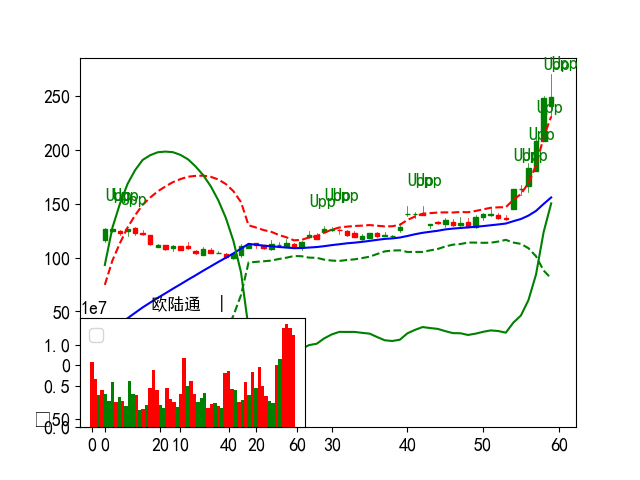

300620 2.56
xratio:0.44 ra_diff:2.56
code: 300620


601606 5.44
xratio:0.81 ra_diff:5.44
code: 601606


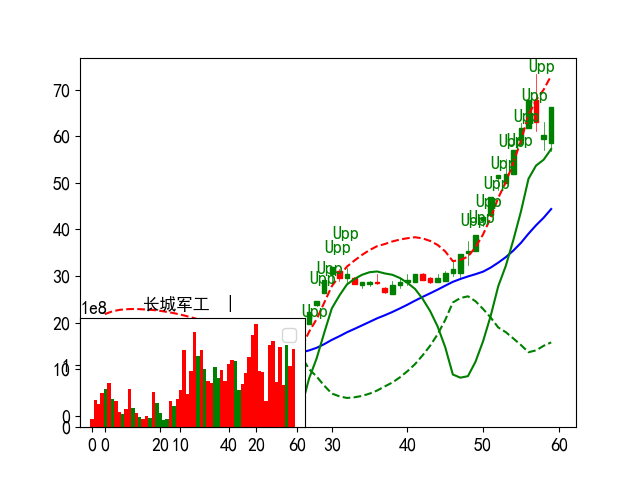

301076 2.4
xratio:0.05 ra_diff:2.4
code: 301076


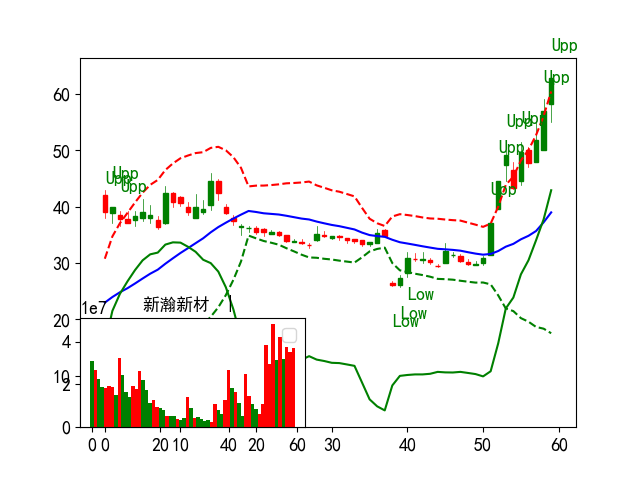

301326 1.89
xratio:0.6 ra_diff:1.89
code: 301326


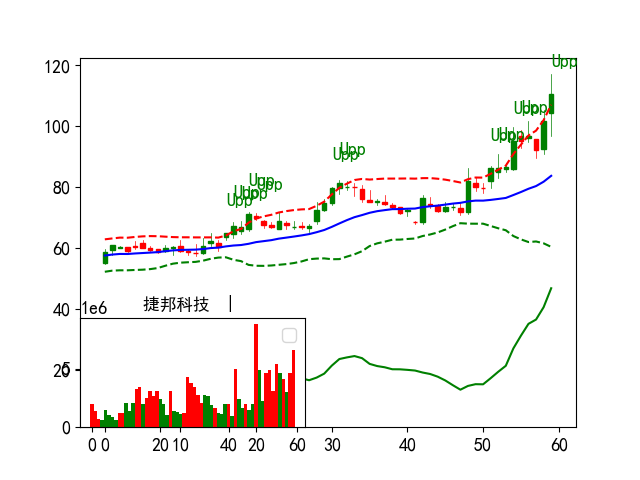

002837 2.89
xratio:0.34 ra_diff:2.89
code: 002837


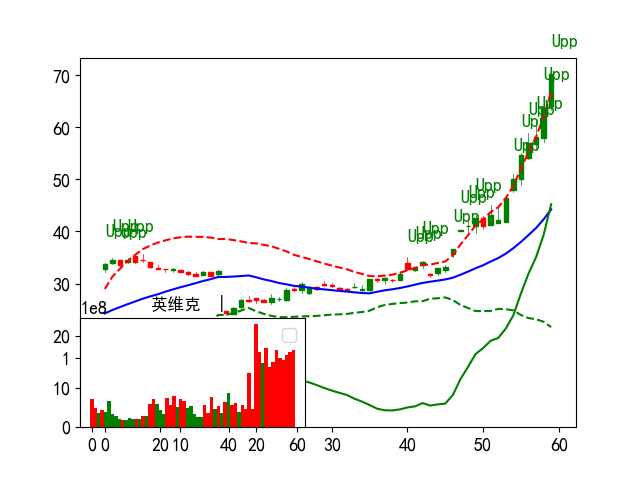

301018 2.22
xratio:0.31 ra_diff:2.22
code: 301018


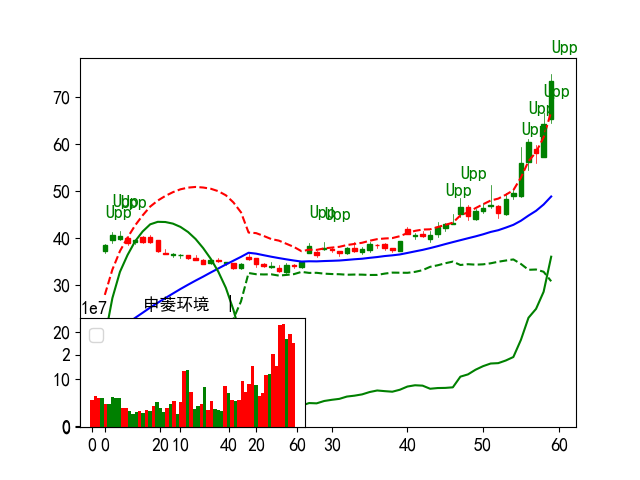

301095 2.01
xratio:0.5 ra_diff:2.01
code: 301095


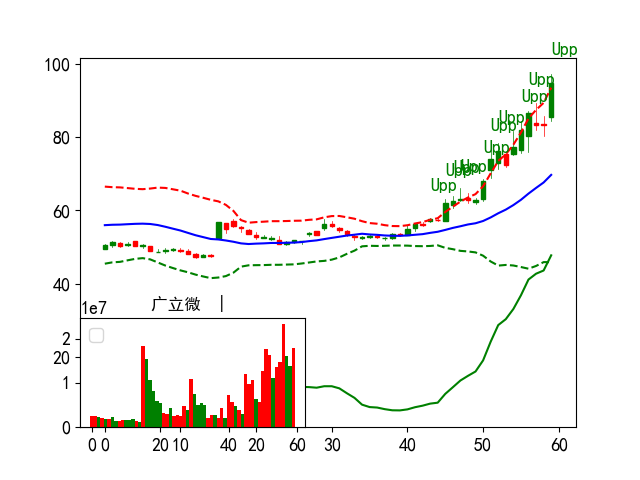

603800 2.55
xratio:0.4 ra_diff:2.55
code: 603800


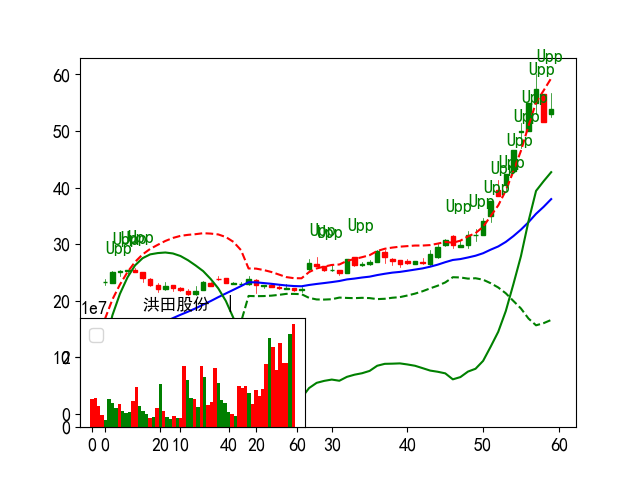

In [89]:
print("df_mask250:%s"%(len(df_mask250.query('couts > 1 and perc > 0'))))
for co in df_mask250.query('couts > 1 and perc > 0').index[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-60:],code=co)

### Tail1 Show Top 主升浪df_masklastd

In [90]:
df_mask250[(df_mask250.date >= lastday_week)][:2]
df_mask250[df_mask250.ra_diff > 1.3].shape

date    lopen   lhigh    llow   close           vol  \
code                                                               
399006 2025-08-18  2550.00  2634.0  2530.0  2606.0  1.772919e+09   
300033 2025-08-18   366.75   427.0   357.0   405.0  3.087982e+07   

              amount  ra_diff     ma10     ma5  ...    idx  couts  nclose  \
code                                            ...                         
399006  8.295864e+11     1.31  2427.40  2503.2  ...  262.0      1     NaN   
300033  1.203551e+10     1.64   316.62   342.7  ...  116.5      3   397.5   

        name    open   high    low  llastp            ticktime   perc  
code                                                                   
399006   NaN     NaN    NaN    NaN     NaN                 NaT    NaN  
300033   同花顺  366.75  427.0  357.0  367.25 2025-08-18 15:00:00  10.28  

[2 rows x 41 columns]

(298, 41)

In [91]:
# df_masklastd = df_mask250[(df_mask250.date >= '2023-02-06') & (df_mask250.perc1d < 21) & (df_mask250.perc2d > 0) &
if resample.upper() =='D':
    df_masklastd = df_mask250[(df_mask250.date >= lastday) & (df_mask250.perc1d < 21) & (df_mask250.perc2d > 0)
                          & ((df_mask250.volsum5d > 10) & (df_mask250.close > df_mask250.ma5) )
                          ]
                          # & ((df_mask250.perc3d > 0) | ((df_mask250.close.shift(2) > df_mask250.ma5.shift(2))) )
else:
    df_masklastd = df_mask250[(df_mask250.date >= lastday_week) & (df_mask250.perc1d < 21) & (df_mask250.perc2d > 0)
                          & ((df_mask250.volsum5d > 20) & (df_mask250.close > df_mask250.ma5) )
                          ]
# (df_mask250.couts == 1) & (df_mask250.perc1d < 21)]

#当下大于上轨
df_masklastd = df_masklastd[df_masklastd.close > df_masklastd.ma5]

print("src:%s  lastd:%s " % (df_mask250.shape, df_masklastd.shape))


if resample.upper() =='M':
    df_masklastd = df_masklastd.sort_values(
        by=['perc1d', 'perc3d'],
        ascending=[0, 0])
else:
    df_masklastd = df_masklastd.sort_values(
        by=['perc3d', 'perc1d'],
        ascending=[0, 0])

# print(
#     (df_masklastd.loc
#      [:, ['name', 'couts', 'date', 'perc1d', 'perc3d', 'perc5d']][:10],
#      df_masklastd.shape,))

# show_tdx_data(df_masklastd)
print(df_masklastd.name.T[:20])
# show_tdx_data(df_masklastd[-10:])
if df_masklastd is not None and len(df_masklastd) > 0:

    code_t = '300675'
    code_t = '605268'
    code_t = '002828'
    code_t = '300418'
    code_t = df_masklastd.index[0]


# df_masklastd.loc[code_t, ['name', 'couts',
#                           'date', 'perc1d', 'perc3d', 'perc5d']]

# df_masklastd.loc[code_t].date


# df_mask250 = groupd250.head(1)

# df_masklastd.loc[code_t].date
# show_tdx_data(df_masklastd.loc[code_t])


# show_tdx_data(df_masklastd.loc[code_t])

src:(475, 41)  lastd:(205, 41) 
code
300843    胜蓝股份
301123    奕东电子
300730    科创信息
300870     欧陆通
300814    中富电路
300811    铂科新材
601609    金田股份
603757    大元泵业
600737    中粮糖业
603221    爱丽家居
300727    润禾材料
300609    汇纳科技
300547    川环科技
002871    伟隆股份
301076    新瀚新材
300803     指南针
600580    卧龙电驱
301128    强瑞技术
300033     同花顺
000561    烽火电子
Name: name, dtype: object


### !!! df_mask_hmax 061

df_mask_hmax:452
603516 3.82
xratio:1.04 ra_diff:3.82
code: 603516


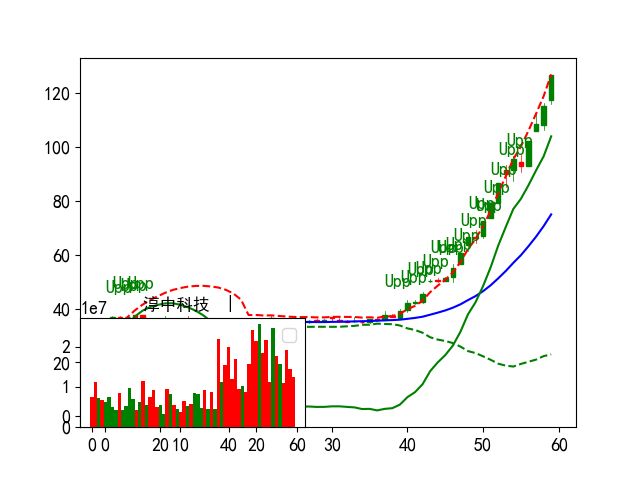

600208 2.11
xratio:0.03 ra_diff:2.11
code: 600208


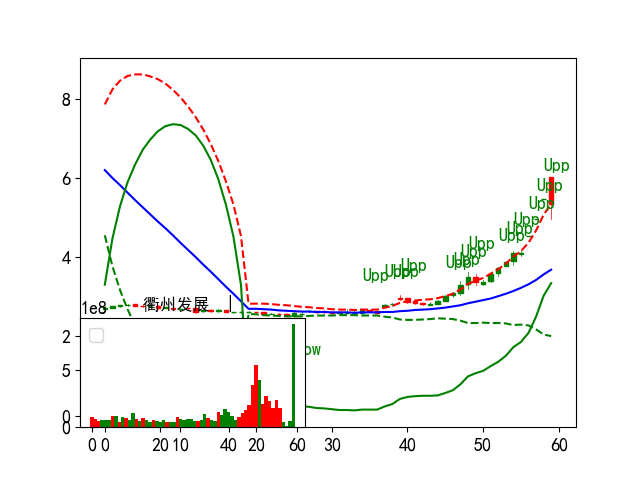

002305 3.07
xratio:0.03 ra_diff:3.07
code: 002305


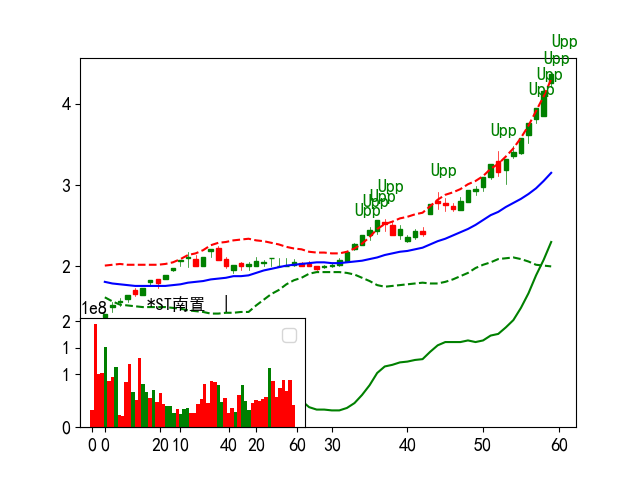

603757 2.42
xratio:0.2 ra_diff:2.42
code: 603757


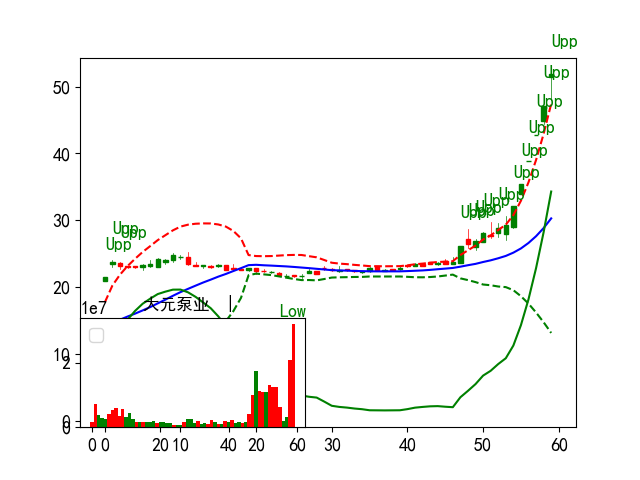

002536 2.4
xratio:0.14 ra_diff:2.4
code: 002536


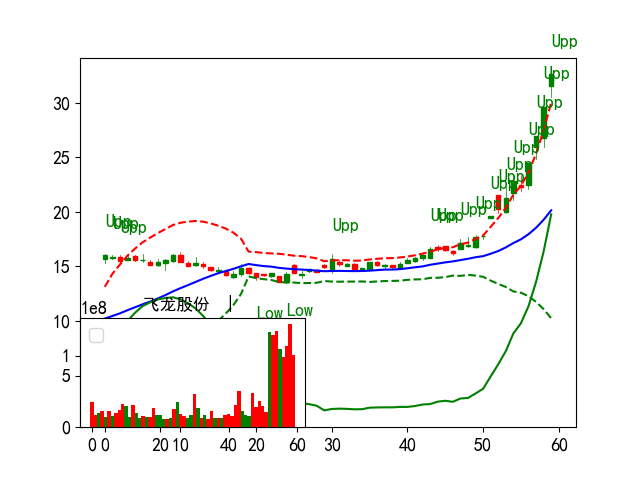

601208 2.2
xratio:0.17 ra_diff:2.2
code: 601208


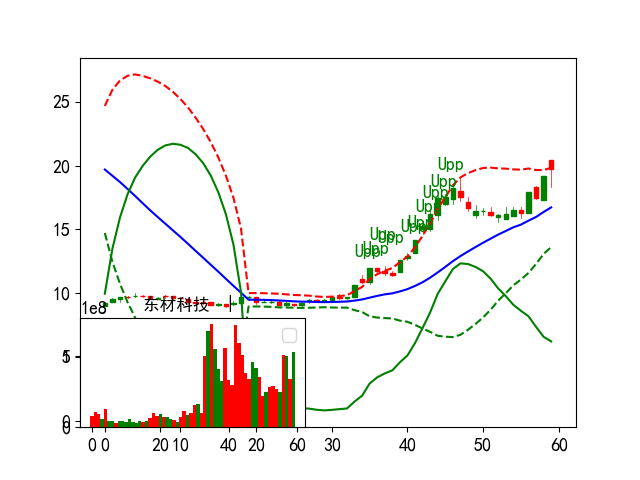

002837 2.89
xratio:0.34 ra_diff:2.89
code: 002837


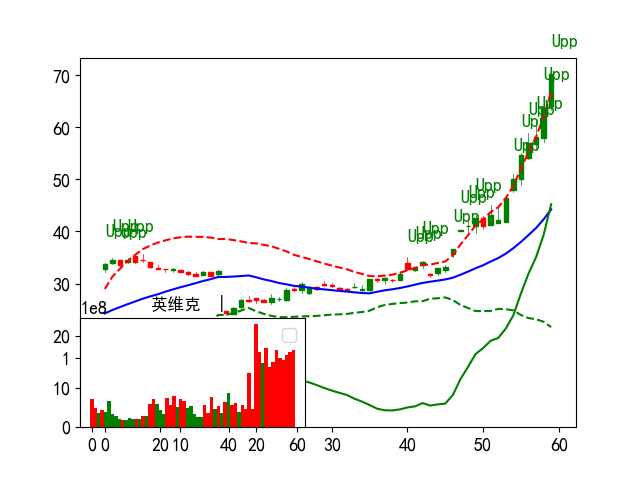

300499 1.88
xratio:0.1 ra_diff:1.88
code: 300499


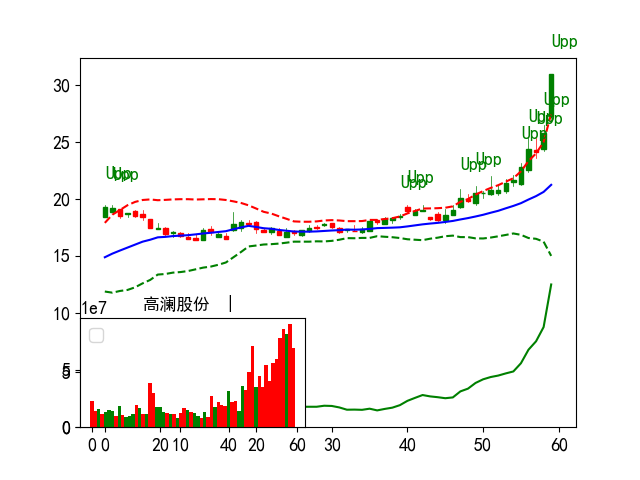

600737 1.66
xratio:0.04 ra_diff:1.66
code: 600737


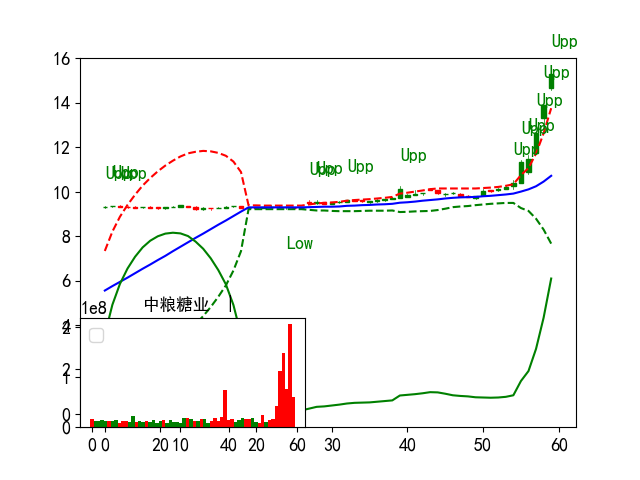

601929 2.44
xratio:0.02 ra_diff:2.44
code: 601929


In [92]:
print("df_mask_hmax:%s"%(len(df_mask_hmax)))
for co in df_mask_hmax.index[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-60:],code=co)

###  df_masklastd 068
    show_ohlc_upper(dfs.loc[co][-60:])

df_masklastd:205
300843 1.97
xratio:0.17 ra_diff:1.97
code: 300843


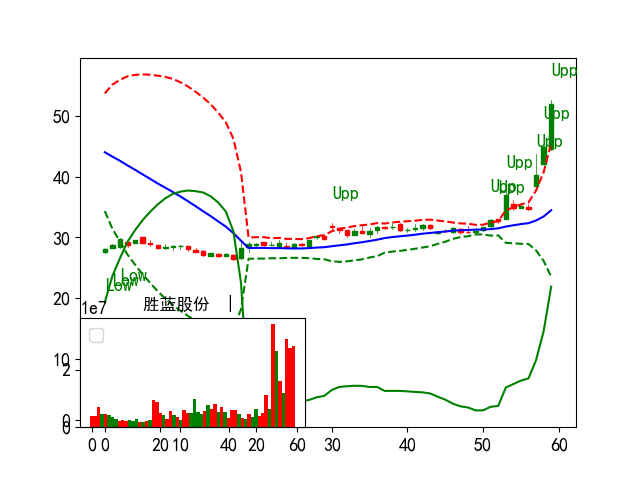

301123 2.34
xratio:0.24 ra_diff:2.34
code: 301123


300730 1.79
xratio:0.07 ra_diff:1.79
code: 300730


300870 2.47
xratio:1.12 ra_diff:2.47
code: 300870


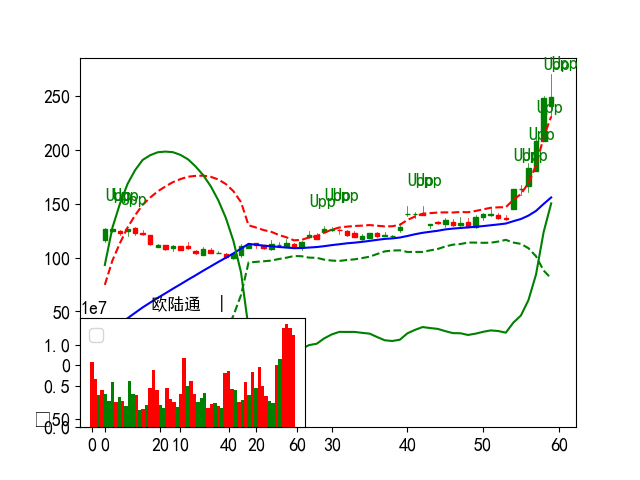

300814 1.88
xratio:0.2 ra_diff:1.88
code: 300814


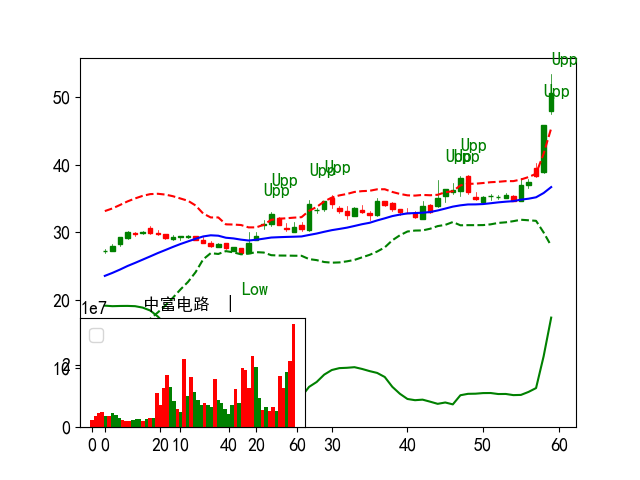

300811 1.89
xratio:0.37 ra_diff:1.89
code: 300811


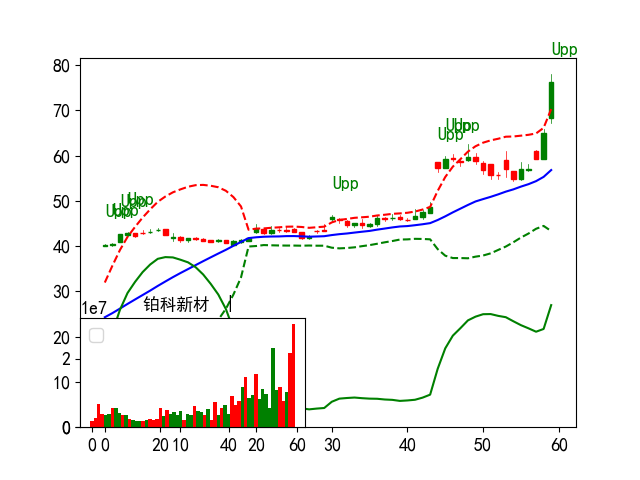

601609 1.95
xratio:0.05 ra_diff:1.95
code: 601609


603757 2.42
xratio:0.2 ra_diff:2.42
code: 603757


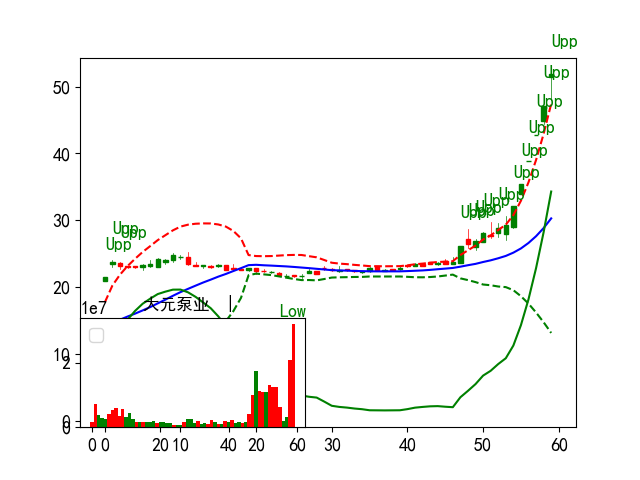

600737 1.66
xratio:0.04 ra_diff:1.66
code: 600737


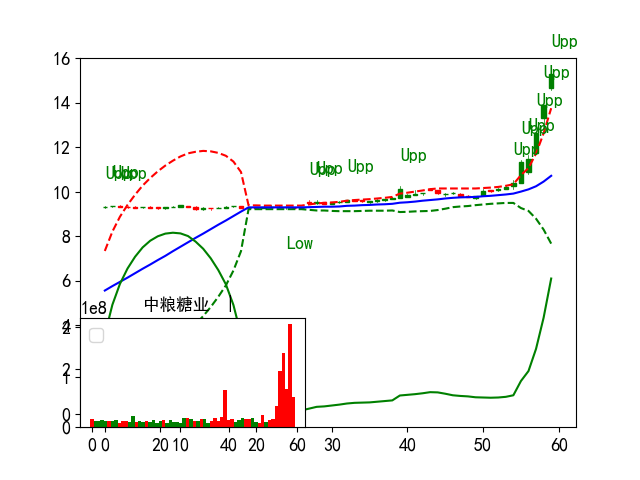

603221 1.59
xratio:0.03 ra_diff:1.59
code: 603221


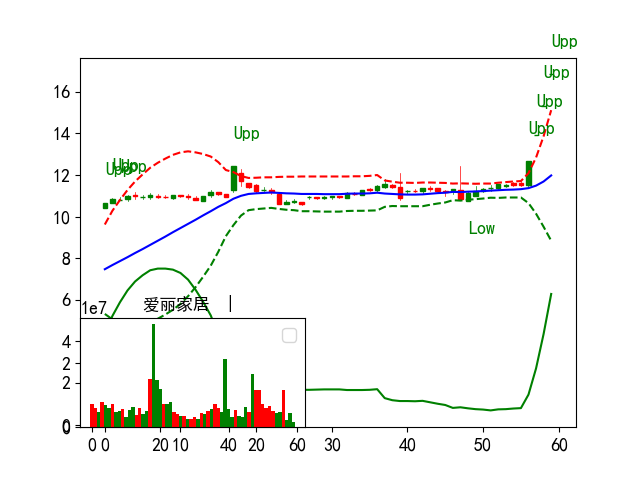

In [93]:
print("df_masklastd:%s"%(len(df_masklastd)))
for co in df_masklastd.index[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-60:],code=co)

### Cross_hmax_250 068

In [94]:
# dfs.loc[code_t].ma5
cross_hmax_250 = [co for co in df_masklastd.index.get_level_values(
    'code') if co in df_mask_hmax.index.get_level_values('code')]
# df_mask250.loc[code_t]
print("cross_hamx:%s" % (len(cross_hmax_250)))
show_tdx_data(df_masklastd.loc[cross_hmax_250],limit=5)

cross_hamx:134
Count:134 41


name  couts       date   perc  ra_diff  xratio     idx     hat  \
code                                                                     
300843  胜蓝股份      2 2025-08-18  15.79     1.97    0.50   20.23   21.92   
301123  奕东电子      1 2025-08-18  19.97     2.34    0.64   16.69   23.58   
300730  科创信息      1 2025-08-18  20.06     1.79    0.10    6.68    6.25   
300870   欧陆通      6 2025-08-18   0.20     2.47    3.92  108.88  150.25   
300814  中富电路      2 2025-08-18  10.42     1.88    0.39   15.38   17.38   

         close  volsum5d  ...  ma250  nclose    llow  vol1d   vol2d   vol3d  \
code                      ...                                                 
300843   52.00      85.4  ...  27.65   49.00   44.38   2.27  -10.47  159.35   
301123   47.28      44.1  ...  18.95   46.91   42.88 -15.58   19.59   67.59   
300730   21.25     330.0  ...  18.41   20.22   18.30  47.81  158.63  152.85   
300870  249.00      48.2  ...  48.97  247.12  230.12  -7.06   -4.33    4.58   
300814   50.66     317.3  ...  27.54   51.03   47.50  55.42   21.23   41.73   

        vol4d   vol5d  perc3d  perc5d  
code                                   
300843 -26.55  -39.23   49.90   49.08  
301123 -10.30  -17.19   49.15   42.20  
300730  -1.50  -27.82   43.29   42.24  
300870  44.82   10.23   35.69   52.41  
300814 -24.46  223.38   35.31   46.33  

[5 rows x 24 columns]

df_mask250:134
601877 1.12
xratio:0.02 ra_diff:1.12
code: 601877


301219 1.44
xratio:0.26 ra_diff:1.44
code: 301219


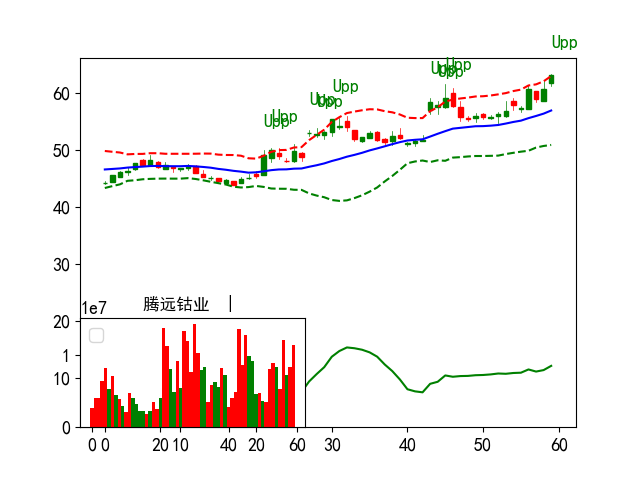

002884 1.19
xratio:0.02 ra_diff:1.19
code: 002884


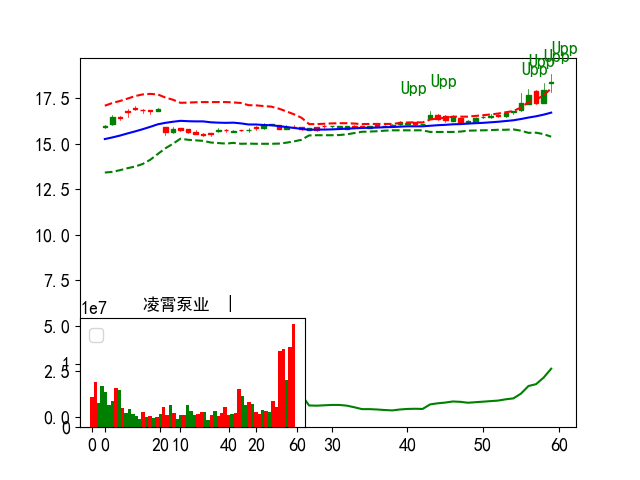

600522 1.16
xratio:0.02 ra_diff:1.16
code: 600522


301315 1.25
xratio:0.16 ra_diff:1.25
code: 301315


301202 1.4
xratio:0.12 ra_diff:1.4
code: 301202


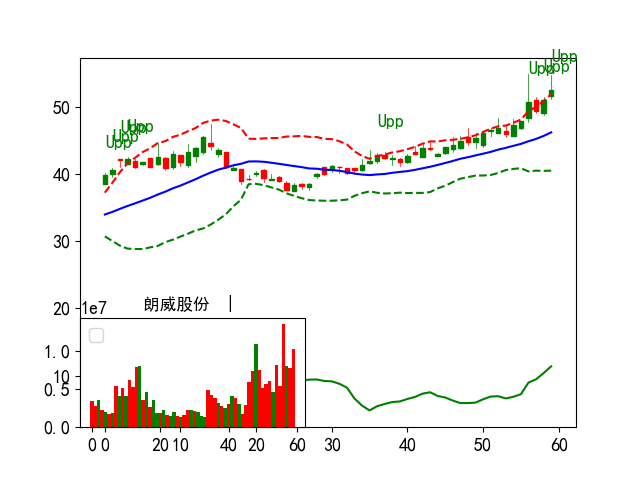

300035 1.32
xratio:0.05 ra_diff:1.32
code: 300035


603306 1.58
xratio:0.24 ra_diff:1.58
code: 603306


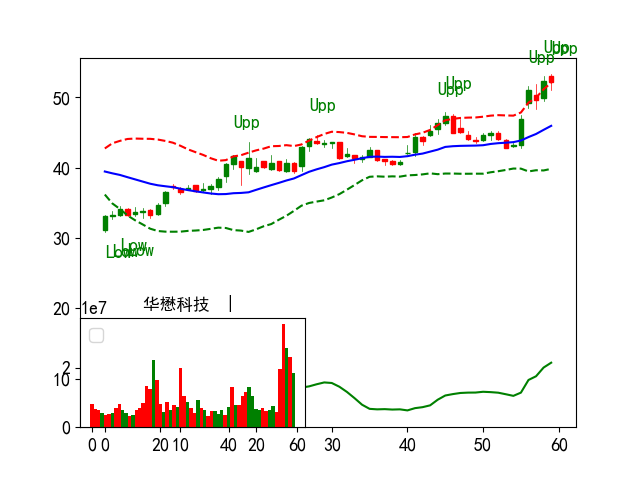

600378 1.2
xratio:0.04 ra_diff:1.2
code: 600378


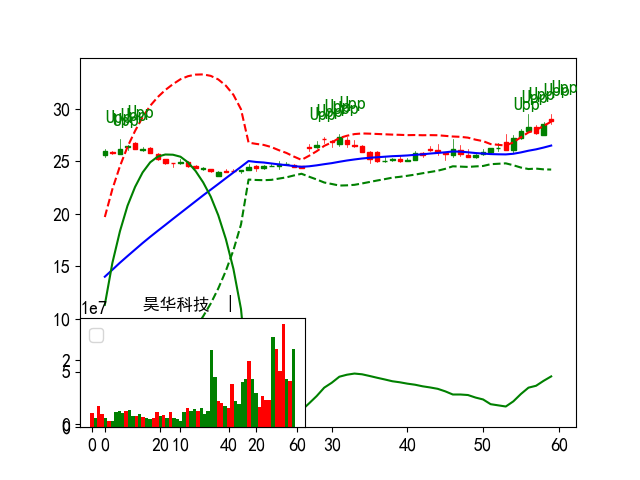

300346 1.16
xratio:0.0 ra_diff:1.16
code: 300346


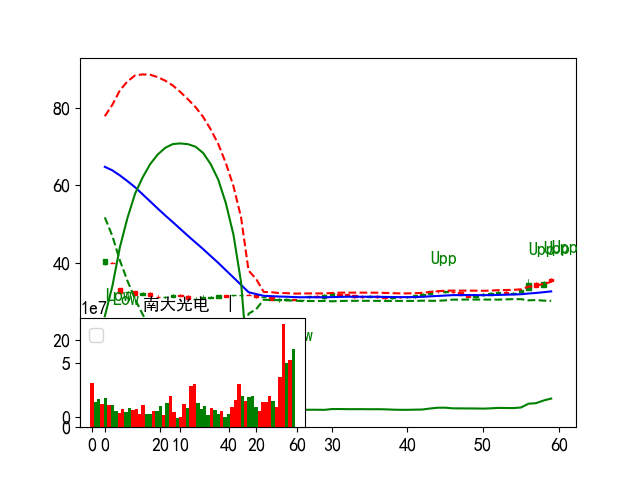

In [95]:
print("df_mask250:%s"%(len(cross_hmax_250)))
# dfs.loc['000002'].shape
for co in cross_hmax_250[-10:]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-60:],code=co)

## 写入061

In [96]:
# write_code_to_blk(df_masklastd.index.tolist(),'061')
# hmax_code = df_mask_hmax[(df_mask_hmax.couts > 1) & (df_mask_hmax.volsum5d > 10) & (df_mask_hmax.volsum5d < 150)].index.tolist()
hmax_code = df_mask_hmax[(df_mask_hmax.couts > 1) ].index.tolist()

# write_code_to_blk(cross_hmax_250,'068')
# write_code_to_blk(hmax_code,'061')

In [97]:
# print(df_masklastd.loc['301255'].date)

# 默认年线筛选

In [98]:
top_temp.shape
top_temp.index

(1195, 35)

Index(['301251', '605060', '601138', '300436', '600619', '600498', '603486',
       '603516', '002859', '603757',
       ...
       '601137', '601002', '301538', '688516', '688336', '688025', '002449',
       '600106', '600623', '600363'],
      dtype='object', name='code', length=1195)

## plt.close('all')

In [99]:
# plt.close('all')

# 写入060